# Experiment 2: Raw scan to scan registration

### Goal: use VICET to bound error in LIDAR odometry when initializing LOAM from a moving platform 

In [1]:
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh
%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook


2023-08-24 13:10:22.858557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 13:10:22.957901: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-24 13:10:23.322897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-24 13:10:23.322948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-24 13:10:24.040774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-24 13:10:24.041015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-24 13:10:24.041163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-24 13:10:24.347881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-24 13:10:24.348055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Autosaving every 180 seconds


In [2]:
#load HD Map
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 10 #10
submap = HD_map[::show_nth]
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1)) 
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [3]:
#load ground truth
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
poses = np.einsum("nij,jk->nik", poses, T_CL)
initial_pose = np.linalg.inv(poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)

In [4]:
#put HD Map and new scan in frame of raw keyframe scan
# idx = 2700 #2750 
# idx = 2020 #test
# idx = 3030 #2nd slow part
idx = 280 #static start in alcove
skip = 55 #10 #how many lidar frames between keyframe and new scan
offset = 10 #works best for 05 dataset
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"
pc1 = np.load(fn1)
pc2 = np.load(fn2)
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#transform everything to pc1 frame
pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
submap_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]
disp.append(Points(submap_in_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314

#uncomment first run (just run once to get ICET object into notebook so we can use associated functions)
it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
               draw = False, group = 2, RM = False, DNN_filter = False)

#remove point from pc1 that hit person holding sensor (likely hurting ICP metrics)
pc1_spherical = tf.cast(it.c2s(pc1), tf.float32)
pc1_too_close = tf.where(pc1_spherical[:,0] < 2. )[:,0]
pc1_not_too_close = tf.where(pc1_spherical[:,0] > 2. )[:,0]
print(len(pc1_too_close))
pc1 = pc1[pc1_not_too_close.numpy()]
# disp.append(Points(pc1[pc1_too_close.numpy()], c = 'black', r = 5)) #red

# DRAW SCANS 1, 2
disp.append(Points(pc1, c = '#a65852', r = 3)) #red
disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

plt.show(disp, "05 Quad With Dynamics Frame #" + str(idx))
ViewInteractiveWidget(plt.window)

2023-08-24 13:10:32.980874: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


iter 0
iter 1
iter 2


2023-08-24 13:10:33.707551: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-24 13:10:33.771351: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x6bd9d00


iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.07589298 -0.10308556 -0.01632602  0.004995    0.00084834  0.00513204], shape=(6,), dtype=float32)
25284


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [10]:
#run VICET
from linear_corrector import LC
# A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
A0 = np.array([0.1*np.random.randn(), 0.1*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])

max_buffer = 2.5 #0.5 #was 2.5

# #add initial offset for LIDAR scan
# trans = np.array([0.5, 0.0, 0.1])
# scan1_lidarframe += trans

#scan to submap
# dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 25, 
#         draw = True, mnp = 25, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 35, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = np.flip(pc1, axis=0), 
#         fid = 50, niter = 100, draw = True, mnp = 50, 
#         RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

# # # scan to scan
# dc = LC(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 50, niter = 100, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
dc = LC(cloud1 = np.flip(pc1, axis=0), cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
        fid = 50, niter = 50, draw = True, mnp = 50, 
        RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)

ViewInteractiveWidget(dc.plt.window)

A0:
 [ 0.04103575 -0.18543409  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0246 -0.1869  0.0001 -0.0017  0.0014 -0.0022] 
 [-0.0001  0.0123 -0.0012 -0.0032 -0.0022  0.0032]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~


/home/derm/ASAR/v3/point_cloud_rectification/linear_corrector.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  period_base = (2*np.pi)/m_hat[-1]


A: 
 [ 0.0124 -0.1846  0.0002 -0.0028  0.0026 -0.0026] 
 [ 0.0006  0.0215 -0.0023 -0.0062 -0.0044  0.0037]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0012 -0.1882 -0.0021 -0.0034  0.0043 -0.005 ] 
 [-0.0023  0.0342 -0.0049 -0.0092 -0.0059  0.007 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0077 -0.1943 -0.0019 -0.0037  0.0053 -0.0083] 
 [-0.009   0.0484 -0.0056 -0.0115 -0.0075  0.0115]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0123 -0.1994 -0.0036 -0.0038  0.0067 -0.011 ] 
 [-0.0154  0.0607 -0.0076 -0.0139 -0.0087  0.0149]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0146 -0.2046 -0.0054 -0.0039  0.0077 -0.0144] 
 [-0.0269  0.0709 -0.0094 -0.0158 -0.0096  0.0193]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0163 -0.2079 -0.0107 -0.004   0.009  -0.0168] 
 [-0.0364  0.0775 -0.0134 -0.0183 -0.0109  0.0225]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0158 -0.2102 -0.0156 -0.0039  0.0104 -0.0192] 
 [-0.0437  0.0818 -0.0172 -0.0207 -0.0121  0.0255]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [11]:
#run rigid ICET
it = ICET(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 50, niter = 10, 
               draw = False, group = 2, RM = False, DNN_filter = False)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.02644935  0.0577637  -0.00990713 -0.01962986  0.00070401 -0.00994859], shape=(6,), dtype=float32)


<IPython.core.display.Javascript object>


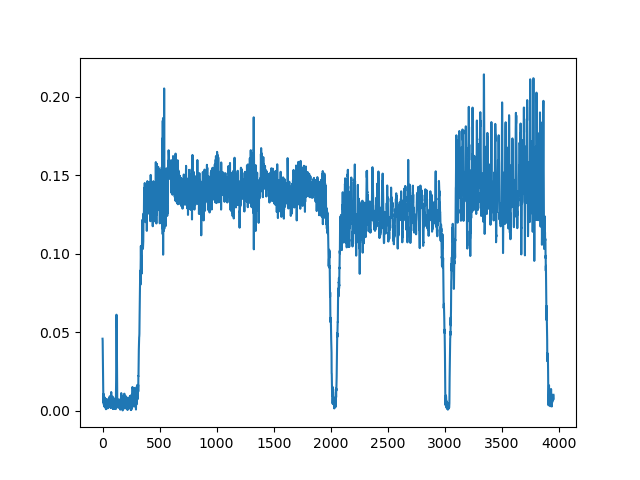

In [12]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
# ax.plot(np.diff(poses[:,0,3]))
# ax.plot(np.diff(poses[:,1,3]))
# ax.plot(np.diff(np.sqrt(poses[:,1,3]**2 + poses[:,0,3]**2)))
ax.plot(np.sqrt(np.diff(poses[:,1,3])**2 + np.diff(poses[:,0,3])**2))

## Load LOAM Trajectory Initialzied From Moving Platform

In [13]:
# # start at 2400 (corner near tree) very obvious forward motion distortion
# # rosbag play --clock -s 70.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag

# ## start at 2800
# # # rosbag play --clock -s 110.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
# LOAM = np.load("results/LOAM/05_LOAM_start_from_2800_v1.npy")
# start_idx = 2810

# # rosbag play --clock -s 100.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
LOAM = np.load("results/LOAM/05_LOAM_start_from_2700_v1.npy")

#  Plot on HD Map

In [104]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 4

fn = "results/LOAM/05_LOAM_start_from_2700_v1.npy"
LOAM_traj = np.load(fn)
# LOAM_traj =  LOAM_traj[10:,:]

#init raw LOAM trajectory and OG LOAM axis
LOAM_axis = np.eye(3)
start_idx = 2689 #2690

end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
disp.append(start_point)

#rotate 135 deg about y axis to align initial motion with +x 
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(0), 0]).as_matrix() #was this for 678
rot_mat = R.from_euler('xyz', [np.deg2rad(10), np.deg2rad(31), np.deg2rad(5.5)]).as_matrix() #test
LOAM_corr = LOAM_traj[:,:3] @ rot_mat 
# LOAM_axis = LOAM_axis @ rot_mat
LOAM_axis = LOAM_axis @ R.from_euler('xyz', [0, np.deg2rad(0), np.deg2rad(-2)]).as_matrix() #test
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
#was this
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
#test
# gt_lidarframe = (poses[start_idx] @ np.linalg.pinv(initial_pose) @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe = np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1)
# gt_lidarframe = (np.linalg.pinv(initial_pose) @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T

gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(0), np.deg2rad(0)]).as_matrix() #test
gt_points = Line(gt_lidarframe[start_idx:start_idx+len(LOAM_traj),:3], c = "black", lw = 4, alpha = 0.5).legend("Actual Motion of Platform")
disp.append(gt_points)

#show LOAM corrected
# LOAM_pts = Points(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, r = ptsize).legend("LOAM")
LOAM_pts = Line(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, lw = 4).legend("LOAM")
disp.append(LOAM_pts)

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
# rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix() #old
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(300)]).as_matrix() #new
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.2)) ##CB2314

# lb = LegendBox([gt_points, start_point, LOAM_pts, VICET_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
lb = LegendBox([gt_points, start_point, LOAM_pts], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


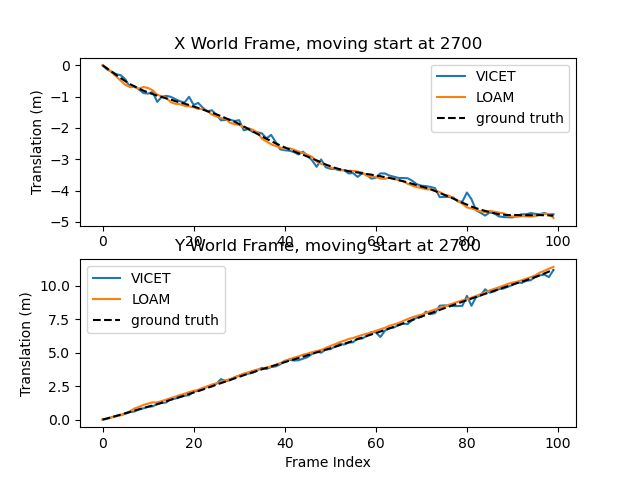

In [105]:
from matplotlib import pyplot as plt

# view_len = 50 #ideal
view_len = 100
# view_len = len(LOAM_corr) #show all data
A_hist = np.load('results/VICET/VICET_constant_keyframe_05_start_from_2700_v1.npy')

fig,ax = plt.subplots(2,1)
ax[0].set_title("X World Frame, moving start at 2700")
ax[0].set_ylabel("Translation (m)")
ax[0].plot(gt_lidarframe[start_idx:start_idx+view_len,0] + A_hist[:view_len,0], label = 'VICET', color = 'C0')
ax[0].plot(LOAM_corr[:view_len,0], label = 'LOAM', color = 'C1')
ax[0].plot(gt_lidarframe[start_idx:start_idx+view_len,0], 'k--', label = 'ground truth')
ax[0].legend(loc='best')

ax[1].set_title("Y World Frame, moving start at 2700")
ax[1].set_ylabel("Translation (m)")
ax[1].set_xlabel("Frame Index")
ax[1].plot(gt_lidarframe[start_idx:start_idx+view_len,1] + A_hist[:view_len,1], label = 'VICET', color = 'C0')
ax[1].plot(LOAM_corr[:view_len,1], label = 'LOAM', color = "C1")
ax[1].plot(gt_lidarframe[start_idx:start_idx+view_len,1], 'k--', label = 'ground truth')
ax[1].legend(loc='best')

### Find ~50 frame region where VICET doesn't explode

In [117]:
from linear_corrector import LC #VICET
st = time.time()

runlen = 100 #50
# start_idx = 2700
# start_idx = 1800 #test
start_idx = 2020

A_hist = np.zeros([runlen, 12]) #VICET
VICET_pred_stds = np.zeros([runlen,12])
X_hist = np.zeros([runlen, 6]) #ICET/ NDT
X_hist_ICP = np.zeros([runlen, 6]) #ICP
raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)
ICP_CD_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
#     05
    offset = 10 #9 #was 10
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + offset) + ".npy"
    pc1 = np.load(fn1)
    fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc2 = np.load(fn2)
    #remove point from pc1 that hit person holding sensor (likely hurting ICP metrics)
    pc1_spherical = tf.cast(it.c2s(pc1), tf.float32)
    pc1_not_too_close = tf.where(pc1_spherical[:,0] > 2. )[:,0]
    pc1 = pc1[pc1_not_too_close.numpy()]

    #transform to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
#     submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    pc2_in_pc1_frame = (np.linalg.pinv(poses[start_idx]) @ poses[start_idx+idx] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    # Run VICET ----------------------------------------------------------
#     A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
#     seed with noisy initial transform to make things fair
    A0 = np.array([0.01*np.random.randn(), 0.01*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])

    # for experiment #1
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
#     dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 25, 
#             draw = False, mnp = 25, RM = True, solver = '12_state', 
#             max_buffer = max_buffer, A0 = A0)
    dc = LC(cloud1 = pc1, cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
        fid = 50, niter = 50, draw = False, mnp = 50, RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)
    A_hist[idx,:] = dc.A
    VICET_pred_stds[idx,:] = dc.pred_stds
#     np.save("results/VICET/VICET_constant_keyframe_05_start_from_2020_v4.npy", A_hist)


 
 Frame # 2020 at 0.00027942657470703125 sec 
 

A0:
 [-0.01749765  0.0034268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0166  0.004   0.0001  0.      0.     -0.    ] 
 [ 0.0001 -0.0004 -0.0006 -0.     -0.      0.    ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0158  0.0044  0.0001  0.      0.0001 -0.    ] 
 [ 0.0002 -0.0008 -0.001  -0.0001 -0.      0.0001]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0151  0.0048  0.0002  0.      0.0001 -0.    ] 
 [ 0.0003 -0.0012 -0.0013 -0.0001 -0.      0.0001]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0144  0.0051  0.0002  0.      0.0001 -0.    ] 
 [ 0.0005 -0.0016 -0.0016 -0.0001 -0.0001  0.0001]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0138  0.0054  0.0002  0.      0.0001 -0.    ] 
 [ 0.0006 -0.0019 -0.0019 -0.0002 -0.0001  0.0001]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0132  0.0056  0.0002  0.      0.0001 -0.0001] 
 [ 0

A: 
 [-0.0141  0.0104  0.0068 -0.0012 -0.0028  0.0001] 
 [-0.0122 -0.027  -0.0202 -0.0021  0.0017 -0.002 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0131  0.0119  0.0087 -0.0013 -0.0032  0.0001] 
 [-0.0137 -0.0305 -0.0236 -0.0022  0.002  -0.0022]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0121  0.0135  0.0103 -0.0015 -0.0034  0.0002] 
 [-0.0154 -0.0341 -0.0267 -0.0022  0.0022 -0.0024]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0112  0.0154  0.0124 -0.0016 -0.0036  0.0003] 
 [-0.0172 -0.0376 -0.0305 -0.0023  0.0024 -0.0026]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0101  0.017   0.0136 -0.0017 -0.0038  0.0003] 
 [-0.0187 -0.0409 -0.0333 -0.0024  0.0026 -0.0028]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.009   0.0188  0.015  -0.0017 -0.0039  0.0004] 
 [-0.0203 -0.0446 -0.0363 -0.0025  0.0027 -0.003 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0082  0.0207  0.0164 -0.0018 -0.004   0.0005] 
 [-0.0218 -0.0474 -0.0391 -0.0026  0.0028 -0.0031]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.0156 -0.0119 -0.0097  0.0004 -0.0065 -0.0016] 
 [-0.0325  0.0158  0.0138  0.0045 -0.0015  0.004 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0161 -0.0116 -0.009   0.0003 -0.0066 -0.0016] 
 [-0.0326  0.0154  0.0138  0.0048 -0.0015  0.004 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0165 -0.0114 -0.0082  0.0002 -0.0067 -0.0015] 
 [-0.0327  0.015   0.0134  0.0051 -0.0015  0.004 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0169 -0.011  -0.0077  0.0001 -0.0068 -0.0015] 
 [-0.0328  0.0146  0.0134  0.0053 -0.0015  0.004 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0196 -0.012  -0.0075  0.     -0.0069 -0.0017] 
 [-0.0399  0.0169  0.0139  0.0056 -0.0015  0.0046]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0201 -0.0116 -0.0069 -0.0001 -0.0069 -0.0017] 
 [-0.0401  0.0164  0.0135  0.0058 -0.0014  0.0046]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0205 -0.0111 -0.0065 -0.0001 -0.007  -0.0017] 
 [-0.0404  0.0158  0.0133  0.006  -0.0014  0.0046]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~

A: 
 [-0.0238 -0.0068 -0.0314  0.0014 -0.0051  0.0019] 
 [ 0.0419  0.0271  0.0453  0.0116  0.0011 -0.0017]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.026  -0.0063 -0.0307  0.0014 -0.0052  0.0021] 
 [ 0.0487  0.0263  0.0447  0.0118  0.0012 -0.0021]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.0286 -0.0057 -0.0298  0.0013 -0.0053  0.0023] 
 [ 0.0564  0.0251  0.0438  0.012   0.0013 -0.0026]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.0315 -0.005  -0.0289  0.0012 -0.0054  0.0026] 
 [ 0.0651  0.0237  0.0429  0.0121  0.0014 -0.0032]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.0347 -0.0042 -0.028   0.0012 -0.0054  0.0029] 
 [ 0.0746  0.022   0.042   0.0123  0.0015 -0.0039]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [-0.0382 -0.0034 -0.0272  0.0011 -0.0055  0.0032] 
 [ 0.085   0.0202  0.041   0.0124  0.0015 -0.0046]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [-0.042  -0.0026 -0.0262  0.001  -0.0056  0.0035] 
 [ 0.0964  0.0182  0.0399  0.0125  0.0016 -0.0053]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~

A: 
 [-0.4678  0.5463 -0.0125  0.0565  0.0421  0.0551] 
 [ 0.9462 -1.0659 -0.5312 -0.1349 -0.0244 -0.1242]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.4766  0.555  -0.0102  0.0576  0.0425  0.0558] 
 [ 0.9592 -1.0783 -0.5453 -0.1382 -0.024  -0.1262]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.4837  0.5617 -0.0127  0.0591  0.0433  0.0563] 
 [ 0.9707 -1.0884 -0.5528 -0.1417 -0.0241 -0.1279]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.4916  0.57   -0.0127  0.0606  0.0439  0.057 ] 
 [ 0.9842 -1.1029 -0.5651 -0.1454 -0.0238 -0.1299]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.4982  0.5762 -0.0139  0.0619  0.0445  0.0574] 
 [ 0.9937 -1.1113 -0.5723 -0.1485 -0.0239 -0.1314]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.5048  0.5782 -0.0174  0.0628  0.0449  0.0577] 
 [ 1.0041 -1.1144 -0.576  -0.151  -0.0236 -0.1327]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.5141  0.5783 -0.018   0.0632  0.0447  0.058 ] 
 [ 1.0173 -1.1125 -0.5799 -0.1525 -0.0227 -0.134 ]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~

A: 
 [-0.1982  0.049  -0.0031  0.0018 -0.007   0.0149] 
 [ 0.4948 -0.0738  0.0293  0.0143  0.01   -0.0391]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [-0.2184  0.0529 -0.0015  0.0017 -0.0069  0.0165] 
 [ 0.5526 -0.0864  0.027   0.0144  0.0099 -0.0431]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [-0.2399  0.0576  0.0008  0.0015 -0.0069  0.0182] 
 [ 0.6168 -0.1012  0.0236  0.0145  0.0097 -0.0475]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [-0.2626  0.0616  0.0029  0.0014 -0.0069  0.02  ] 
 [ 0.6849 -0.1154  0.0206  0.0146  0.0095 -0.0521]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [-0.2905  0.0677  0.0054  0.0012 -0.0069  0.0221] 
 [ 0.7636 -0.1351  0.0172  0.0148  0.0093 -0.0578]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [-0.3207  0.0742  0.0078  0.001  -0.0068  0.0245] 
 [ 0.8481 -0.1554  0.0142  0.015   0.0091 -0.0638]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [-0.353   0.0809  0.0107  0.0007 -0.0067  0.027 ] 
 [ 0.9418 -0.1785  0.0104  0.0153  0.0087 -0.0704]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~

A: 
 [-0.6885  0.3167  0.0147  0.0046  0.0013  0.0576] 
 [ 1.5127 -0.7131 -0.0158  0.0124 -0.004  -0.1523]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.6816  0.318   0.0207  0.0036  0.0005  0.0577] 
 [ 1.5222 -0.7026 -0.0174  0.0142 -0.0038 -0.1519]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.6811  0.3174  0.0281  0.0026 -0.0002  0.0579] 
 [ 1.5296 -0.6912 -0.022   0.0157 -0.0036 -0.1518]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.6813  0.3317  0.0276  0.0027  0.0003  0.0598] 
 [ 1.5192 -0.7242 -0.0232  0.0156 -0.0042 -0.1563]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.6763  0.3309  0.0332  0.0019 -0.0002  0.0599] 
 [ 1.5296 -0.7122 -0.0265  0.0169 -0.0042 -0.156 ]

 
 Frame # 2027 at 42.92249870300293 sec 
 

A0:
 [-0.01749765  0.0034268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0156  0.0015 -0.0021  0.0026  0.0004 -0.    ] 
 [ 0.0004  0.0018 -0.0039 -0.0003  0.000

A: 
 [-0.083   0.0421  0.0451  0.0085 -0.0018  0.0045] 
 [ 0.0814 -0.1335 -0.1378 -0.014   0.0064 -0.0133]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.1172  0.0635  0.0562  0.0112 -0.002   0.0078] 
 [ 0.1322 -0.1984 -0.1802 -0.0183  0.0081 -0.0222]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.1529  0.082   0.0502  0.0133 -0.0004  0.0109] 
 [ 0.1933 -0.2483 -0.1908 -0.0214  0.0067 -0.0299]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.1406  0.1045  0.042   0.0145  0.0009  0.015 ] 
 [ 0.2089 -0.3039 -0.1887 -0.0224  0.0053 -0.0398]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.1276  0.1402  0.0377  0.0149  0.0013  0.02  ] 
 [ 0.227  -0.3893 -0.186  -0.0219  0.0048 -0.0517]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.1211  0.1665  0.0392  0.0146  0.0009  0.0258] 
 [ 0.2586 -0.4596 -0.1863 -0.0199  0.005  -0.0657]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.1119  0.2009  0.0411  0.0141  0.0003  0.0314] 
 [ 0.2919 -0.5444 -0.1843 -0.0175  0.0055 -0.0791]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [-0.0564  0.0496  0.0713  0.0053 -0.0072  0.0196] 
 [ 0.1368 -0.2248 -0.1608  0.0037  0.0105 -0.0506]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0505  0.058   0.071   0.0047 -0.0073  0.0229] 
 [ 0.1505 -0.2483 -0.1543  0.0057  0.0098 -0.0582]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0396  0.0542  0.0712  0.004  -0.0076  0.0252] 
 [ 0.1589 -0.2502 -0.1474  0.0079  0.0095 -0.0637]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0307  0.0639  0.0725  0.0035 -0.0076  0.0275] 
 [ 0.1695 -0.2724 -0.1448  0.0095  0.009  -0.0687]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.03    0.0553  0.0743  0.0029 -0.008   0.028 ] 
 [ 0.1871 -0.2611 -0.1419  0.0112  0.0088 -0.0703]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.0258  0.0477  0.0766  0.0024 -0.0082  0.0289] 
 [ 0.2004 -0.2516 -0.1414  0.0125  0.0087 -0.0728]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.0294  0.0371  0.0776  0.002  -0.0082  0.0296] 
 [ 0.2219 -0.235  -0.1394  0.0136  0.0082 -0.0748]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [-0.113   0.0763  0.0701  0.0012 -0.0077  0.0269] 
 [ 0.4379 -0.2062 -0.1081  0.0125  0.0062 -0.0668]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.1038  0.0692  0.0707  0.001  -0.0077  0.0268] 
 [ 0.4549 -0.1946 -0.1071  0.013   0.0061 -0.0672]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.1364  0.0789  0.0695  0.0008 -0.0073  0.0293] 
 [ 0.5233 -0.2195 -0.1027  0.0135  0.0051 -0.0733]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.1267  0.0722  0.0729  0.0006 -0.0077  0.0291] 
 [ 0.5415 -0.2082 -0.1072  0.0138  0.0055 -0.0732]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.1187  0.0642  0.0748  0.0005 -0.0078  0.0288] 
 [ 0.5599 -0.1953 -0.1091  0.014   0.0057 -0.073 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.1559  0.0752  0.0727  0.0004 -0.0074  0.0315] 
 [ 0.6359 -0.2259 -0.1038  0.0143  0.0046 -0.0798]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.1468  0.0657  0.0743  0.0003 -0.0076  0.0311] 
 [ 0.6564 -0.2115 -0.1052  0.0146  0.0049 -0.0796]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~

A: 
 [-0.0582 -0.0462  0.0239  0.0003 -0.0077  0.0039] 
 [ 0.0752  0.1151  0.0077  0.0189  0.0064 -0.0016]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [-0.0583 -0.0482  0.0236  0.0002 -0.0077  0.0039] 
 [ 0.0777  0.1179  0.0091  0.0191  0.0063 -0.0016]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [-0.0587 -0.0504  0.0232  0.0002 -0.0077  0.0039] 
 [ 0.08    0.1209  0.0101  0.0192  0.0063 -0.0016]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [-0.0591 -0.0523  0.0226  0.0002 -0.0077  0.0039] 
 [ 0.0821  0.1233  0.0116  0.0193  0.0062 -0.0016]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [-0.0596 -0.0545  0.0222  0.0002 -0.0077  0.0038] 
 [ 0.0842  0.126   0.0127  0.0194  0.0062 -0.0016]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0593 -0.0563  0.022   0.0002 -0.0077  0.0038] 
 [ 0.0864  0.1284  0.013   0.0194  0.0062 -0.0014]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0597 -0.0584  0.0219  0.0002 -0.0077  0.0038] 
 [ 0.0883  0.131   0.0134  0.0194  0.0062 -0.0014]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~

A: 
 [-0.0583 -0.0421  0.0406 -0.0002 -0.0095  0.0038] 
 [ 0.0955  0.0801 -0.0164  0.0172  0.0082 -0.0044]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0622 -0.0419  0.0407 -0.0003 -0.0094  0.0041] 
 [ 0.1066  0.0782 -0.0166  0.0173  0.0081 -0.0052]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0663 -0.0418  0.0408 -0.0003 -0.0094  0.0044] 
 [ 0.1184  0.0765 -0.0165  0.0173  0.008  -0.006 ]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0708 -0.0413  0.0412 -0.0003 -0.0094  0.0048] 
 [ 0.1316  0.0742 -0.0172  0.0174  0.0079 -0.0069]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0759 -0.0408  0.0416 -0.0004 -0.0093  0.0052] 
 [ 0.146   0.0713 -0.0178  0.0174  0.0078 -0.0078]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [-0.0811 -0.0404  0.0417 -0.0004 -0.0093  0.0056] 
 [ 0.1615  0.0685 -0.0178  0.0175  0.0077 -0.0089]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [-0.0867 -0.0398  0.0419 -0.0005 -0.0092  0.006 ] 
 [ 0.1784  0.0654 -0.0178  0.0176  0.0076 -0.01  ]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~

A: 
 [-0.6355  0.1254  0.0734 -0.0026  0.0007  0.0439] 
 [ 1.5561 -0.366  -0.0802  0.0193 -0.0092 -0.1213]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [-0.6402  0.121   0.0736 -0.0025  0.001   0.0438] 
 [ 1.5583 -0.3578 -0.0819  0.0191 -0.0096 -0.1216]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [-0.6447  0.1176  0.0744 -0.0026  0.0012  0.0437] 
 [ 1.5597 -0.351  -0.0839  0.019  -0.01   -0.1219]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.6492  0.1136  0.0736 -0.0026  0.0014  0.0437] 
 [ 1.5609 -0.3444 -0.0838  0.019  -0.0103 -0.1223]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.6543  0.1095  0.0735 -0.0026  0.0016  0.0437] 
 [ 1.5624 -0.3366 -0.0846  0.0189 -0.0107 -0.1227]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.6585  0.1059  0.0742 -0.0026  0.0017  0.0436] 
 [ 1.5639 -0.3299 -0.0866  0.0188 -0.011  -0.123 ]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.664   0.1032  0.0742 -0.0026  0.0019  0.0436] 
 [ 1.5643 -0.3243 -0.0876  0.0187 -0.0114 -0.1235]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~

A: 
 [-0.7664 -0.0515  0.0629 -0.0048  0.0023  0.0434] 
 [ 1.7449 -0.0827 -0.0531  0.0236 -0.0071 -0.1157]

 
 Frame # 2035 at 92.99401259422302 sec 
 

A0:
 [-0.01749765  0.0034268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0165 -0.0053  0.009   0.0006 -0.0013  0.0001] 
 [-0.0014  0.0185 -0.0106  0.0022  0.0022  0.0005]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0202 -0.0096  0.0164  0.0009 -0.0024  0.0005] 
 [ 0.0036  0.0296 -0.0187  0.0041  0.0038  0.0003]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0232 -0.0126  0.0208  0.0012 -0.0032  0.0009] 
 [ 0.0084  0.0378 -0.0218  0.0059  0.005   0.0003]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0255 -0.0154  0.0242  0.0013 -0.0039  0.0011] 
 [ 0.0118  0.0458 -0.0235  0.0076  0.0059  0.0003]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0273 -0.0176  0.0267  0.0013 -0.0044  0.0014] 
 [ 0.0159  0.0526 -0.0241  0.009   0.0066  0

A: 
 [-0.0957  0.0661  0.069   0.0077 -0.0009  0.0129] 
 [ 0.1555 -0.1973 -0.152  -0.0053  0.0048 -0.0325]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.1023  0.0692  0.0725  0.0073 -0.001   0.0139] 
 [ 0.1826 -0.2028 -0.1545 -0.004   0.0047 -0.0345]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.11    0.0723  0.0768  0.007  -0.001   0.0151] 
 [ 0.2123 -0.2069 -0.1605 -0.0032  0.0043 -0.0367]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.1167  0.0784  0.0796  0.0066 -0.0009  0.0162] 
 [ 0.2435 -0.2171 -0.1625 -0.0021  0.004  -0.0387]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.1066  0.0763  0.081   0.0062 -0.0011  0.0161] 
 [ 0.2556 -0.2129 -0.1601 -0.0007  0.0039 -0.0385]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.1213  0.0759  0.0827  0.0058 -0.0011  0.0176] 
 [ 0.2959 -0.2169 -0.16    0.0002  0.0035 -0.042 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.1097  0.0744  0.0853  0.0054 -0.0014  0.0179] 
 [ 0.307  -0.2138 -0.1609  0.0012  0.0036 -0.0427]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [-0.0322  0.0329  0.0644  0.0072 -0.0028  0.0063] 
 [ 0.1564 -0.176  -0.1235  0.0008  0.0074 -0.0224]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0296  0.0325  0.0657  0.007  -0.0028  0.0065] 
 [ 0.158  -0.1761 -0.1246  0.0011  0.0073 -0.0227]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0265  0.0315  0.0654  0.0069 -0.0029  0.0065] 
 [ 0.1596 -0.1781 -0.1217  0.0017  0.0073 -0.0232]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0237  0.031   0.0657  0.0067 -0.003   0.0066] 
 [ 0.1607 -0.1799 -0.1202  0.0022  0.0073 -0.0235]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0211  0.0308  0.0659  0.0067 -0.003   0.0067] 
 [ 0.1617 -0.1813 -0.1197  0.0024  0.0072 -0.0239]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0187  0.0303  0.0662  0.0066 -0.003   0.0068] 
 [ 0.1623 -0.1832 -0.1197  0.0025  0.0071 -0.0243]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0169  0.0298  0.0665  0.0066 -0.0029  0.0069] 
 [ 0.1638 -0.1831 -0.1195  0.0027  0.0069 -0.0246]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.0784 -0.0651  0.0296  0.0024 -0.0043  0.0021] 
 [ 0.0615  0.1396 -0.031   0.0155  0.0054  0.0066]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.0793 -0.0673  0.0294  0.0024 -0.0043  0.0021] 
 [ 0.0636  0.142  -0.0305  0.0155  0.0053  0.0066]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.0803 -0.0692  0.0297  0.0023 -0.0043  0.0021] 
 [ 0.0654  0.1441 -0.0307  0.0156  0.0053  0.0066]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [-0.0808 -0.071   0.03    0.0023 -0.0043  0.0022] 
 [ 0.0676  0.1468 -0.0314  0.0157  0.0052  0.0067]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [-0.0803 -0.0713  0.0304  0.0022 -0.0043  0.0021] 
 [ 0.0684  0.1473 -0.032   0.0157  0.0051  0.007 ]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [-0.0806 -0.0729  0.0305  0.0022 -0.0042  0.0021] 
 [ 0.0701  0.1489 -0.0322  0.0157  0.0051  0.0071]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [-0.0801 -0.0734  0.0308  0.0022 -0.0042  0.0021] 
 [ 0.0706  0.1489 -0.0326  0.0157  0.005   0.0074]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

A: 
 [ 0.1282  0.1387  0.0759  0.0023 -0.0009  0.0429] 
 [ 0.1343 -0.3502 -0.1182  0.0118  0.001  -0.0977]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.1303  0.1355  0.0765  0.0022 -0.0008  0.0433] 
 [ 0.1374 -0.3468 -0.1185  0.0119  0.0008 -0.0989]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.1347  0.1386  0.0775  0.002  -0.0009  0.0449] 
 [ 0.1405 -0.3537 -0.119   0.0123  0.0008 -0.1026]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.1392  0.1388  0.0785  0.0019 -0.0008  0.0457] 
 [ 0.1435 -0.3553 -0.1203  0.0124  0.0006 -0.1047]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.1384  0.1336  0.0799  0.002  -0.0007  0.0458] 
 [ 0.1492 -0.3464 -0.1242  0.012   0.0004 -0.1051]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.1399  0.1297  0.0806  0.0019 -0.0006  0.0461] 
 [ 0.1533 -0.341  -0.1252  0.0121  0.0002 -0.1062]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.141   0.1263  0.0813  0.0019 -0.0005  0.0465] 
 [ 0.1563 -0.3368 -0.127   0.0119  0.     -0.1074]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [ 0.0011 -0.0186  0.0452  0.004  -0.0024  0.0021] 
 [-0.0417  0.0273 -0.0468  0.0109  0.0049  0.0071]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.0016 -0.0185  0.0453  0.004  -0.0024  0.0021] 
 [-0.0419  0.0267 -0.0471  0.0109  0.0049  0.0072]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.002  -0.0184  0.0455  0.004  -0.0024  0.0021] 
 [-0.042   0.026  -0.0476  0.0108  0.0049  0.0072]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0025 -0.0183  0.0456  0.004  -0.0024  0.0022] 
 [-0.0422  0.0253 -0.0476  0.0109  0.0049  0.0072]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.0031 -0.0181  0.0458  0.004  -0.0024  0.0022] 
 [-0.0426  0.0244 -0.0482  0.0108  0.0049  0.0072]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.0036 -0.018   0.0459  0.004  -0.0024  0.0022] 
 [-0.0428  0.0237 -0.0483  0.0108  0.0049  0.0073]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.004  -0.0177  0.0461  0.004  -0.0024  0.0022] 
 [-0.0431  0.0229 -0.0485  0.0108  0.0049  0.0073]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

A: 
 [0.0165 0.0331 0.1282 0.008  0.0157 0.0221] 
 [-0.0335 -0.1795 -0.3194 -0.0201 -0.0161 -0.0457]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [0.0182 0.0302 0.1314 0.0079 0.0159 0.0221] 
 [-0.0317 -0.1736 -0.327  -0.0202 -0.0166 -0.0456]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [0.0196 0.027  0.1337 0.0077 0.016  0.022 ] 
 [-0.0305 -0.1676 -0.3322 -0.0202 -0.017  -0.0455]

 
 Frame # 2042 at 137.79537177085876 sec 
 

A0:
 [-0.01749765  0.0034268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0227 -0.0032  0.0067  0.0007 -0.0009  0.0003] 
 [ 0.003   0.012  -0.0055  0.0015  0.0012  0.0003]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0284 -0.0316  0.0124  0.0012 -0.0016  0.0008] 
 [ 0.0095  0.053  -0.0104  0.003   0.0023 -0.0002]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.032  -0.0358  0.0162  0.0017 -0.0019  0.0012] 
 [ 0.0117  0.0632 -0.0147  0.0039  0.0029 -0.0001]
~~~~~~~~

A: 
 [-0.024  -0.0096  0.0236  0.0037 -0.0009  0.0011] 
 [ 0.0068  0.0202 -0.0328  0.0005  0.0022  0.0014]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0272 -0.0125  0.0271  0.004  -0.001   0.0014] 
 [ 0.0075  0.0245 -0.0378  0.0009  0.0025  0.0015]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0284 -0.0158  0.0295  0.0042 -0.0012  0.0017] 
 [ 0.01    0.0301 -0.0414  0.0013  0.0028  0.0017]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0306 -0.0253  0.0311  0.0044 -0.0013  0.002 ] 
 [ 0.0153  0.0421 -0.0438  0.0017  0.003   0.0016]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0332 -0.0341  0.0326  0.0044 -0.0014  0.0024] 
 [ 0.0197  0.0525 -0.0459  0.0022  0.0032  0.0015]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0358 -0.042   0.0344  0.0044 -0.0014  0.0027] 
 [ 0.0238  0.0624 -0.0484  0.0027  0.0033  0.0014]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0379 -0.0499  0.0357  0.0044 -0.0015  0.003 ] 
 [ 0.0284  0.0733 -0.0505  0.003   0.0034  0.0014]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [-0.0396  0.3939  0.0528  0.0061  0.0015  0.057 ] 
 [ 0.1835 -0.8418 -0.1288 -0.0042 -0.0005 -0.1192]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0271  0.4274  0.0553  0.0055  0.0012  0.061 ] 
 [ 0.1961 -0.9032 -0.1292 -0.0029 -0.0005 -0.1267]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0192  0.4566  0.0589  0.0051  0.0012  0.0648] 
 [ 0.2047 -0.9582 -0.1328 -0.0021 -0.0007 -0.1342]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.0119  0.4875  0.0634  0.0045  0.0013  0.0683] 
 [ 0.2114 -1.0145 -0.1374 -0.0012 -0.001  -0.1411]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.0036  0.5169  0.0667  0.0041  0.0013  0.0716] 
 [ 0.2195 -1.0686 -0.1403 -0.0003 -0.0012 -0.1475]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [0.0041 0.5464 0.0707 0.0036 0.0013 0.0743] 
 [ 0.2279 -1.1199 -0.1445  0.0005 -0.0015 -0.1529]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [0.0125 0.5658 0.0719 0.0032 0.0014 0.0758] 
 [ 0.2278 -1.1583 -0.1446  0.0014 -0.002  -0.1566]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [0.018

A: 
 [-0.2842  0.2221  0.0585  0.0006  0.006   0.0689] 
 [ 0.0664 -0.8391 -0.1612  0.0036 -0.0098 -0.178 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.2917  0.2165  0.0649 -0.0005  0.0061  0.072 ] 
 [ 0.061  -0.8435 -0.17    0.0052 -0.0107 -0.1863]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.2695  0.2095  0.0753 -0.0014  0.0061  0.0755] 
 [ 0.0758 -0.8422 -0.1835  0.0059 -0.011  -0.1928]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.2805  0.2054  0.0841 -0.0023  0.0064  0.0785] 
 [ 0.0682 -0.8471 -0.1994  0.007  -0.0122 -0.2011]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.2582  0.1962  0.086  -0.0029  0.0067  0.0824] 
 [ 0.0827 -0.8467 -0.2014  0.0077 -0.0129 -0.2086]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.2408  0.1924  0.0933 -0.0036  0.0068  0.0839] 
 [ 0.0945 -0.844  -0.2114  0.0083 -0.0135 -0.2116]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.2263  0.1873  0.0971 -0.0042  0.0072  0.0855] 
 [ 0.104  -0.8424 -0.2163  0.009  -0.0143 -0.215 ]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

A: 
 [-0.0185 -0.0521  0.028   0.0037 -0.0028  0.0034] 
 [ 0.0285  0.0765 -0.0432  0.0089  0.0018  0.0046]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [-0.0187 -0.0532  0.0284  0.0036 -0.0028  0.0035] 
 [ 0.0293  0.0774 -0.0437  0.009   0.0017  0.0046]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [-0.0195 -0.0537  0.0288  0.0036 -0.0027  0.0036] 
 [ 0.0313  0.0769 -0.0445  0.009   0.0016  0.0045]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [-0.0193 -0.0546  0.0293  0.0035 -0.0026  0.0036] 
 [ 0.0319  0.0774 -0.0454  0.009   0.0014  0.0045]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [-0.0191 -0.0555  0.0298  0.0035 -0.0026  0.0037] 
 [ 0.0324  0.0777 -0.0465  0.009   0.0013  0.0046]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0191 -0.0563  0.0304  0.0035 -0.0025  0.0037] 
 [ 0.0327  0.0779 -0.0478  0.0089  0.0012  0.0046]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0191 -0.057   0.0308  0.0034 -0.0025  0.0038] 
 [ 0.0333  0.0785 -0.0481  0.009   0.0012  0.0047]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

A: 
 [-0.0758  0.7719  0.1293 -0.008   0.0084  0.1014] 
 [ 0.1484 -1.6435 -0.2437  0.0096 -0.0213 -0.2357]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0647  0.8051  0.1382 -0.0089  0.0077  0.1039] 
 [ 0.1539 -1.7121 -0.2574  0.0112 -0.0206 -0.2425]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0672  0.8053  0.135  -0.0092  0.0084  0.1022] 
 [ 0.1521 -1.7151 -0.2522  0.0121 -0.0221 -0.2404]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [-0.0542  0.8357  0.1435 -0.0097  0.008   0.1054] 
 [ 0.1594 -1.7784 -0.2669  0.0128 -0.0218 -0.2486]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [-0.0606  0.8366  0.1404 -0.0099  0.0087  0.1038] 
 [ 0.1556 -1.7823 -0.2614  0.0136 -0.0232 -0.2467]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [-0.0465  0.8714  0.1497 -0.0107  0.0081  0.1071] 
 [ 0.1631 -1.8497 -0.2748  0.0148 -0.0228 -0.2549]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [-0.0321  0.9031  0.1564 -0.0114  0.0079  0.1104] 
 [ 0.1706 -1.9114 -0.2847  0.0158 -0.0229 -0.2628]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

A: 
 [-0.0904 -0.0724  0.052   0.0001 -0.0003  0.0033] 
 [ 0.1178  0.1687 -0.0744  0.009   0.0002 -0.0059]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.0919 -0.0732  0.0523  0.0001 -0.0002  0.0034] 
 [ 0.1204  0.1706 -0.0752  0.009   0.0001 -0.006 ]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.0934 -0.0756  0.0527  0.     -0.0002  0.0033] 
 [ 0.1224  0.1748 -0.076   0.009  -0.0001 -0.0061]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.0945 -0.0778  0.0531 -0.     -0.0001  0.0033] 
 [ 0.1247  0.179  -0.0767  0.0091 -0.0002 -0.0061]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.0956 -0.0803  0.053  -0.     -0.0001  0.0033] 
 [ 0.1269  0.1832 -0.0766  0.0091 -0.0003 -0.0061]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0967 -0.0826  0.0531 -0.0001  0.      0.0033] 
 [ 0.1292  0.1873 -0.0768  0.0091 -0.0005 -0.0062]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0981 -0.085   0.0535 -0.0001  0.0001  0.0033] 
 [ 0.131   0.1913 -0.0775  0.0091 -0.0006 -0.0063]

 
 Frame # 2049 at 183.58113646507

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0431  0.015   0.0145  0.003   0.0003  0.0015] 
 [ 0.0315 -0.0534 -0.0432 -0.005   0.0007 -0.0055]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0604  0.0252  0.0273  0.0054  0.0007  0.0025] 
 [ 0.0472 -0.0954 -0.082  -0.0093  0.001  -0.0094]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0744  0.0362  0.0357  0.0073  0.0016  0.0035] 
 [ 0.0578 -0.1351 -0.1122 -0.013   0.0007 -0.0126]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0982  0.0517  0.0345  0.0091  0.0034  0.005 ] 
 [ 0.0766 -0.1861 -0.1242 -0.0162 -0.0014 -0.0176]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.1183  0.0696  0.0295  0.0111  0.006   0.0065] 
 [ 0.0911 -0.2366 -0.1329 -0.0203 -0.0045 -0.0221]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.1295  0.0904  0.0208  0.0126  0.0086  0.0083] 
 [ 0.0964 -0.2899 -0.1307 -0.0234 -0.008  -0.027 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.1409  0.1123  0.012   0.014   0.0115  0.0102] 
 [ 0.1002 -0.3417 -0.1288 -0.0264 -0.0122 -0.0318]
~~~~~~

A: 
 [-0.157   0.184   0.0182  0.0138  0.0121  0.0218] 
 [ 0.1163 -0.464  -0.1434 -0.0235 -0.0105 -0.0574]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.1332  0.2436  0.0323  0.0134  0.0116  0.0296] 
 [ 0.1351 -0.5645 -0.1656 -0.0235 -0.0097 -0.071 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.1131  0.2995  0.0428  0.0128  0.0113  0.0368] 
 [ 0.1506 -0.6613 -0.1812 -0.0229 -0.0092 -0.084 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0933  0.3495  0.0523  0.0124  0.0111  0.0433] 
 [ 0.1676 -0.7481 -0.1969 -0.0227 -0.0088 -0.0957]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0778  0.3954  0.0607  0.0117  0.011   0.0492] 
 [ 0.1803 -0.8314 -0.2089 -0.0219 -0.0089 -0.1067]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0634  0.4411  0.0681  0.0108  0.0106  0.0551] 
 [ 0.191  -0.9149 -0.2176 -0.0207 -0.0087 -0.1179]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0466  0.4837  0.0749  0.0104  0.0109  0.0605] 
 [ 0.2055 -0.9895 -0.2293 -0.0205 -0.009  -0.1279]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [0.0167 0.3868 0.0888 0.0144 0.015  0.0543] 
 [ 0.0844 -0.8303 -0.2743 -0.0277 -0.0078 -0.1174]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [0.0275 0.424  0.0953 0.0138 0.0153 0.0603] 
 [ 0.093  -0.9012 -0.2854 -0.0274 -0.0083 -0.129 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [0.0391 0.4658 0.1053 0.013  0.0153 0.066 ] 
 [ 0.1015 -0.976  -0.3004 -0.0269 -0.0085 -0.1399]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [0.0475 0.4975 0.1108 0.0122 0.0153 0.0705] 
 [ 0.1079 -1.0369 -0.3084 -0.026  -0.0088 -0.149 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [0.0579 0.5346 0.1168 0.011  0.0149 0.0757] 
 [ 0.1158 -1.109  -0.3139 -0.0243 -0.0089 -0.1594]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [0.0548 0.5459 0.0941 0.0107 0.0174 0.0774] 
 [ 0.1122 -1.1463 -0.2821 -0.0229 -0.0127 -0.1646]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [0.0466 0.5489 0.076  0.0106 0.0195 0.0777] 
 [ 0.1056 -1.172  -0.2561 -0.022  -0.0159 -0.1678]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [0.0634 0.5998 0.0876 0.0095 0.0181 

A: 
 [-0.0048 -0.0382  0.0414  0.0017 -0.0018  0.0005] 
 [-0.0013  0.0994 -0.0451  0.0079  0.0093  0.0028]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.0056 -0.0397  0.0414  0.0017 -0.0018  0.0005] 
 [-0.      0.1017 -0.0451  0.0079  0.0093  0.0026]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.0064 -0.0412  0.0414  0.0017 -0.0019  0.0006] 
 [ 0.0013  0.104  -0.045   0.008   0.0094  0.0025]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [-0.0072 -0.0426  0.0415  0.0017 -0.0019  0.0006] 
 [ 0.0025  0.1061 -0.0454  0.008   0.0094  0.0024]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [-0.0079 -0.0441  0.0416  0.0017 -0.0019  0.0006] 
 [ 0.0039  0.1085 -0.0455  0.008   0.0095  0.0022]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [-0.0087 -0.0455  0.0417  0.0017 -0.0019  0.0007] 
 [ 0.0052  0.1107 -0.0455  0.008   0.0095  0.0021]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [-0.0095 -0.047   0.0415  0.0017 -0.0019  0.0007] 
 [ 0.0065  0.1128 -0.0455  0.008   0.0095  0.002 ]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

A: 
 [-0.3049 -0.0849  0.0602  0.0005  0.014   0.0485] 
 [-0.0788 -0.6655 -0.1749 -0.0085 -0.0221 -0.167 ]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.2827 -0.0849  0.0666 -0.0005  0.0125  0.0479] 
 [-0.0637 -0.6632 -0.1763 -0.0059 -0.0206 -0.1652]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.2953 -0.0955  0.069  -0.001   0.0116  0.0467] 
 [-0.0721 -0.6761 -0.1744 -0.004  -0.0196 -0.1657]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.3098 -0.1066  0.0738 -0.0015  0.0105  0.046 ] 
 [-0.0804 -0.6866 -0.1773 -0.0019 -0.0181 -0.1668]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.2901 -0.1043  0.0798 -0.0023  0.0095  0.0457] 
 [-0.0688 -0.6837 -0.1817  0.0006 -0.0167 -0.1648]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.2954 -0.1195  0.0808 -0.0025  0.009   0.047 ] 
 [-0.0724 -0.6937 -0.1797  0.002  -0.0161 -0.1706]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.281  -0.1162  0.0855 -0.0031  0.0082  0.0464] 
 [-0.0637 -0.6909 -0.1828  0.0039 -0.0151 -0.1678]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [-0.291   0.3787 -0.025   0.0145  0.0424  0.065 ] 
 [ 0.0084 -1.0188 -0.1601 -0.0432 -0.0558 -0.1655]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [-0.2949  0.3781 -0.026   0.0144  0.0433  0.0665] 
 [ 0.0063 -1.0244 -0.1606 -0.0437 -0.0573 -0.1696]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [-0.2994  0.3897 -0.0262  0.0143  0.0442  0.068 ] 
 [ 0.0092 -1.0511 -0.1623 -0.0441 -0.0589 -0.1736]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [-0.3023  0.3988 -0.0287  0.0147  0.0456  0.0699] 
 [ 0.0125 -1.0759 -0.164  -0.0456 -0.0611 -0.1787]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [-0.3009  0.3987 -0.0342  0.0158  0.0482  0.0728] 
 [ 0.0163 -1.0892 -0.167  -0.049  -0.0645 -0.1865]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.2942  0.3773 -0.0264  0.0135  0.046   0.0792] 
 [ 0.0199 -1.0979 -0.163  -0.0439 -0.0627 -0.2047]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.294   0.3569 -0.0206  0.0113  0.0445  0.0859] 
 [ 0.0194 -1.1114 -0.1585 -0.0404 -0.0619 -0.2197]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

A: 
 [-0.2723  0.3584 -0.0024  0.0075  0.0391  0.0673] 
 [ 0.0166 -0.8449 -0.1646 -0.0325 -0.0546 -0.1653]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.272   0.3696  0.001   0.0068  0.0391  0.0682] 
 [ 0.02   -0.8587 -0.1669 -0.0313 -0.0552 -0.1669]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.2706  0.3731  0.0028  0.0063  0.039   0.0691] 
 [ 0.0221 -0.8618 -0.1666 -0.0303 -0.0555 -0.169 ]

 
 Frame # 2057 at 236.0687460899353 sec 
 

A0:
 [-0.01749765  0.0034268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0182  0.0074 -0.0012  0.0006 -0.0005  0.001 ] 
 [ 0.0044 -0.0002 -0.0042 -0.0006 -0.0003 -0.0006]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0174  0.0088 -0.0022  0.0009 -0.0011  0.0017] 
 [ 0.0069  0.0029 -0.006  -0.0007 -0.0004 -0.0009]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0162  0.007  -0.0014  0.001  -0.0016  0.0025] 
 [ 0.0095  0.0113 -0.0093 -0.0006 -0.0004 

A: 
 [-0.051   0.0557 -0.0662  0.0196  0.0149  0.0017] 
 [ 0.0417 -0.1722 -0.0512 -0.0368 -0.0182 -0.0065]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0553  0.0704 -0.0814  0.0233  0.0185  0.0026] 
 [ 0.0422 -0.2151 -0.0587 -0.0444 -0.0223 -0.0093]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0601  0.0868 -0.0959  0.0268  0.0222  0.0032] 
 [ 0.0431 -0.2641 -0.0646 -0.0519 -0.0267 -0.0113]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0666  0.1053 -0.1092  0.0299  0.0258  0.0041] 
 [ 0.0443 -0.3126 -0.0705 -0.0589 -0.0309 -0.0139]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0725  0.1172 -0.1194  0.0324  0.0286  0.0048] 
 [ 0.0429 -0.3482 -0.0762 -0.0644 -0.0339 -0.0159]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.079   0.1322 -0.1318  0.0351  0.0324  0.0057] 
 [ 0.0427 -0.3897 -0.0822 -0.071  -0.0383 -0.0185]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0921  0.1462 -0.1324  0.0365  0.0338  0.0061] 
 [ 0.0467 -0.4285 -0.0963 -0.0745 -0.0397 -0.0199]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [-0.0618  0.132  -0.1087  0.0309  0.0318  0.004 ] 
 [ 0.0036 -0.3379 -0.0852 -0.0625 -0.0352 -0.0136]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0665  0.1466 -0.1146  0.0321  0.0338  0.0047] 
 [ 0.003  -0.362  -0.0898 -0.0658 -0.0374 -0.0148]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0712  0.1605 -0.1197  0.0334  0.0356  0.0055] 
 [ 0.0027 -0.3842 -0.094  -0.0689 -0.0392 -0.0162]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.0753  0.1753 -0.1249  0.0346  0.0377  0.0063] 
 [ 0.003  -0.4071 -0.0986 -0.0723 -0.0415 -0.0176]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.0798  0.1908 -0.1288  0.0352  0.0391  0.0072] 
 [ 0.0032 -0.4298 -0.102  -0.0744 -0.0431 -0.0192]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0836  0.2004 -0.132   0.0359  0.0402  0.0076] 
 [ 0.0023 -0.4455 -0.105  -0.0761 -0.0441 -0.0198]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0877  0.2169 -0.1361  0.0367  0.0419  0.0083] 
 [ 0.0029 -0.4673 -0.1087 -0.0786 -0.046  -0.0211]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

A: 
 [-0.0317 -0.0059 -0.0402  0.0237  0.0203  0.0053] 
 [ 0.022  -0.092  -0.0794 -0.0303 -0.0245 -0.0076]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0319 -0.0072 -0.0409  0.0238  0.0208  0.0056] 
 [ 0.0216 -0.0915 -0.0799 -0.0307 -0.0254 -0.0081]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0331 -0.0039 -0.041   0.0237  0.0211  0.0054] 
 [ 0.0213 -0.0992 -0.0796 -0.0306 -0.0258 -0.0073]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.0339 -0.0021 -0.0411  0.0237  0.0214  0.0054] 
 [ 0.0213 -0.1046 -0.0795 -0.0306 -0.0265 -0.0072]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.0342 -0.0012 -0.0421  0.0238  0.0221  0.0058] 
 [ 0.0212 -0.1062 -0.0802 -0.0313 -0.0275 -0.0078]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.0338 -0.0053 -0.0422  0.0238  0.0225  0.0062] 
 [ 0.0208 -0.1006 -0.0809 -0.0315 -0.0283 -0.0084]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.034  -0.0057 -0.0423  0.0238  0.0229  0.0065] 
 [ 0.0206 -0.1008 -0.0811 -0.0315 -0.029  -0.0088]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

A: 
 [ 0.1328 -0.0623  0.0618  0.0065 -0.0016 -0.0236] 
 [-0.255   0.0012 -0.1025  0.0109  0.0106  0.0594]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.1287 -0.0648  0.0613  0.0066 -0.0017 -0.0251] 
 [-0.2576  0.0042 -0.1017  0.0109  0.0107  0.063 ]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.1249 -0.0719  0.0595  0.0067 -0.0016 -0.0268] 
 [-0.2602  0.0145 -0.0987  0.0108  0.0106  0.067 ]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.1251 -0.0737  0.0587  0.0068 -0.0016 -0.0276] 
 [-0.2601  0.0127 -0.0981  0.0104  0.0107  0.0689]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.1221 -0.0773  0.0571  0.0069 -0.0017 -0.0289] 
 [-0.262   0.0162 -0.0951  0.0105  0.0108  0.0721]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.1201 -0.0784  0.0573  0.0069 -0.0018 -0.03  ] 
 [-0.2631  0.0147 -0.0954  0.0104  0.0111  0.0749]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.1179 -0.0789  0.0567  0.007  -0.0019 -0.0311] 
 [-0.2644  0.0123 -0.0945  0.0103  0.0113  0.0776]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

A: 
 [-0.0425  0.1868  0.0577  0.0286  0.0353 -0.0165] 
 [-0.0003 -0.5257 -0.3333 -0.0618 -0.0376  0.0354]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0457  0.2006  0.0484  0.0306  0.0386 -0.0166] 
 [ 0.0015 -0.5576 -0.3363 -0.0671 -0.0415  0.0357]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0486  0.2146  0.039   0.0326  0.0423 -0.0166] 
 [ 0.0035 -0.5872 -0.3393 -0.0727 -0.0464  0.0359]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [-0.0521  0.2261  0.0313  0.0343  0.0449 -0.0171] 
 [ 0.0043 -0.6132 -0.3418 -0.0772 -0.0497  0.0371]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [-0.0554  0.2376  0.0238  0.0361  0.0477 -0.0177] 
 [ 0.0053 -0.6385 -0.3446 -0.0818 -0.0533  0.0386]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [-0.0767  0.2495  0.0339  0.0377  0.0492 -0.0183] 
 [ 0.0231 -0.6609 -0.3837 -0.0873 -0.054   0.0402]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [-0.0802  0.2574  0.0278  0.0391  0.0511 -0.0192] 
 [ 0.0238 -0.6838 -0.3859 -0.0908 -0.0561  0.0423]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

A: 
 [-0.2171  0.3703  0.0901  0.0473  0.0625 -0.0115] 
 [ 0.1298 -0.788  -0.6815 -0.1352 -0.0599  0.0258]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.2163  0.3828  0.0864  0.0477  0.0636 -0.0115] 
 [ 0.1305 -0.8052 -0.6806 -0.1365 -0.0614  0.0264]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.2161  0.3899  0.0829  0.0485  0.0649 -0.012 ] 
 [ 0.1315 -0.8173 -0.6812 -0.1385 -0.0631  0.0277]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [-0.2176  0.4011  0.0801  0.0489  0.066  -0.0121] 
 [ 0.1344 -0.8339 -0.6819 -0.1398 -0.0647  0.0285]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [-0.2212  0.4108  0.0786  0.0493  0.0668 -0.0124] 
 [ 0.1388 -0.8472 -0.6843 -0.141  -0.0656  0.0295]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.221   0.4191  0.0765  0.0497  0.0672 -0.0126] 
 [ 0.1392 -0.8597 -0.6834 -0.1416 -0.0661  0.0305]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.2227  0.4266  0.0763  0.0495  0.067  -0.013 ] 
 [ 0.1409 -0.8717 -0.6828 -0.1412 -0.0659  0.0318]

 
 Frame # 2064 at 282.60991621017

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0166  0.0096 -0.0034 -0.0005 -0.0007  0.0005] 
 [ 0.0038 -0.003   0.0031  0.001  -0.0003 -0.0004]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0157  0.0146 -0.0061 -0.0009 -0.0012  0.0009] 
 [ 0.007  -0.0039  0.0063  0.002  -0.0007 -0.0008]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0144  0.0187 -0.0085 -0.0013 -0.0016  0.0013] 
 [ 0.0096 -0.0046  0.0092  0.0028 -0.001  -0.0011]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0123  0.0222 -0.0104 -0.0015 -0.0019  0.0016] 
 [ 0.0111 -0.0051  0.0117  0.0034 -0.0013 -0.0013]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0111  0.0244 -0.012  -0.0018 -0.0021  0.0018] 
 [ 0.0132 -0.0037  0.0139  0.0039 -0.0016 -0.0016]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0098  0.0269 -0.0129 -0.002  -0.0023  0.0021] 
 [ 0.015  -0.0034  0.0154  0.0044 -0.0018 -0.0019]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0084  0.029  -0.0138 -0.0022 -0.0024  0.0023] 
 [ 0.0163 -0.0028  0.0171  0.0048 -0.0021 -0.0021]
~~~~~~

A: 
 [-0.0268 -0.0303 -0.0275 -0.0005 -0.0036  0.0088] 
 [ 0.0705  0.0804 -0.0074 -0.006  -0.009  -0.0152]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0273 -0.0291 -0.0263 -0.0009 -0.0039  0.0096] 
 [ 0.0747  0.0844 -0.0091 -0.0055 -0.0093 -0.0161]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0271 -0.0312 -0.025  -0.0012 -0.0041  0.0103] 
 [ 0.078   0.0918 -0.0116 -0.0053 -0.0097 -0.0172]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0269 -0.0328 -0.023  -0.0015 -0.0043  0.0109] 
 [ 0.0811  0.0984 -0.0135 -0.0048 -0.0101 -0.018 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0282 -0.0328 -0.0198 -0.002  -0.0046  0.0113] 
 [ 0.0854  0.102  -0.0173 -0.0042 -0.0102 -0.0185]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0278 -0.0343 -0.0164 -0.0024 -0.0049  0.0118] 
 [ 0.0877  0.1083 -0.0216 -0.0037 -0.0103 -0.019 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0306 -0.0346 -0.012  -0.0027 -0.0051  0.0122] 
 [ 0.0932  0.112  -0.0283 -0.0033 -0.0105 -0.0195]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [ 0.1163  0.0157  0.0042 -0.0009 -0.0042 -0.004 ] 
 [-0.0959 -0.026  -0.0387  0.0048 -0.0044  0.0118]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.1216  0.0154  0.0056 -0.0011 -0.0043 -0.0042] 
 [-0.1002 -0.0264 -0.0396  0.0052 -0.0045  0.0123]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.1271  0.0154  0.0068 -0.0012 -0.0043 -0.0043] 
 [-0.1048 -0.0276 -0.0407  0.0054 -0.0047  0.0128]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.1331  0.0146  0.0081 -0.0013 -0.0043 -0.0045] 
 [-0.1101 -0.0283 -0.0423  0.0055 -0.0049  0.0133]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.1394  0.0144  0.0099 -0.0014 -0.0043 -0.0048] 
 [-0.1161 -0.0296 -0.0446  0.0056 -0.005   0.014 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.1451  0.0143  0.0108 -0.0014 -0.0042 -0.005 ] 
 [-0.1213 -0.0311 -0.0456  0.0057 -0.0052  0.0145]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.1506  0.0141  0.0121 -0.0015 -0.0043 -0.0052] 
 [-0.1265 -0.032  -0.0468  0.0059 -0.0053  0.0151]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.0363  0.0482 -0.0133 -0.0002 -0.0063  0.0031] 
 [ 0.0127 -0.0202  0.0068  0.0082  0.0017  0.0003]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.0384  0.0479 -0.0133 -0.0002 -0.0063  0.0031] 
 [ 0.011  -0.02    0.0071  0.0082  0.0017  0.0005]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.0401  0.0477 -0.0134 -0.0002 -0.0063  0.0031] 
 [ 0.0096 -0.0199  0.0075  0.0083  0.0018  0.0006]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [ 0.0419  0.0473 -0.0136 -0.0002 -0.0064  0.0031] 
 [ 0.0081 -0.0197  0.0082  0.0083  0.0018  0.0007]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [ 0.0433  0.047  -0.014  -0.0002 -0.0063  0.003 ] 
 [ 0.0069 -0.0196  0.0089  0.0083  0.0018  0.0008]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.0449  0.0467 -0.0139 -0.0002 -0.0064  0.003 ] 
 [ 0.0055 -0.0196  0.0091  0.0083  0.0018  0.0008]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.0465  0.0468 -0.0137 -0.0002 -0.0064  0.003 ] 
 [ 0.0042 -0.0201  0.0088  0.0083  0.0019  0.0009]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

A: 
 [-0.0051  0.2768 -0.0713  0.048   0.0372  0.0242] 
 [-0.0966 -0.4592 -0.4286 -0.1237 -0.0232 -0.0688]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0062  0.2721 -0.0682  0.0472  0.0362  0.0253] 
 [-0.096  -0.4524 -0.4307 -0.122  -0.0215 -0.0721]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.0011  0.2516 -0.0619  0.0444  0.0334  0.0227] 
 [-0.1139 -0.3881 -0.4187 -0.1152 -0.0186 -0.0651]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.0002  0.2556 -0.0635  0.0443  0.0333  0.0245] 
 [-0.1064 -0.4031 -0.4147 -0.1147 -0.0185 -0.0702]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0016  0.2289 -0.0569  0.0413  0.0304  0.0223] 
 [-0.1103 -0.3349 -0.3996 -0.1071 -0.0158 -0.0648]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0062  0.1912 -0.0504  0.0389  0.0278  0.02  ] 
 [-0.1073 -0.2471 -0.3889 -0.1008 -0.0132 -0.0591]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0134  0.1958 -0.0552  0.0386  0.0277  0.0212] 
 [-0.0882 -0.2606 -0.3744 -0.0993 -0.0135 -0.0626]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [-0.0651  0.1986  0.0047  0.0506  0.0285  0.0194] 
 [ 0.0054 -0.306  -0.55   -0.122   0.0029 -0.055 ]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [-0.0623  0.1974  0.0054  0.0507  0.0283  0.0201] 
 [ 0.0006 -0.303  -0.5536 -0.1223  0.0036 -0.0569]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [-0.0602  0.1985  0.0039  0.0506  0.028   0.0207] 
 [-0.0037 -0.3025 -0.5503 -0.122   0.0042 -0.0585]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [-0.0606  0.1985  0.0015  0.0503  0.0274  0.0214] 
 [-0.0044 -0.3051 -0.5419 -0.1207  0.0049 -0.0608]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [-0.0547  0.2026 -0.      0.0499  0.027   0.022 ] 
 [-0.0127 -0.3104 -0.536  -0.1195  0.0056 -0.0625]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.0471  0.1723  0.0009  0.0462  0.0237  0.0197] 
 [-0.0278 -0.2245 -0.501  -0.1092  0.008  -0.0564]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.0493  0.1738 -0.0029  0.046   0.0236  0.0205] 
 [-0.0214 -0.2305 -0.4893 -0.1082  0.0079 -0.0587]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

A: 
 [-0.0482  0.3641 -0.084   0.0534  0.0228  0.0111] 
 [-0.0515 -0.5608 -0.3718 -0.1165  0.0145 -0.0236]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0501  0.3623 -0.0879  0.0535  0.0225  0.0112] 
 [-0.0495 -0.558  -0.3641 -0.1163  0.0152 -0.0239]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0518  0.3608 -0.0901  0.0536  0.022   0.0114] 
 [-0.0474 -0.5565 -0.359  -0.116   0.016  -0.0248]

 
 Frame # 2072 at 335.33370661735535 sec 
 

A0:
 [-0.01749765  0.0034268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0348  0.01   -0.0019  0.0082  0.0038  0.0014] 
 [ 0.0221 -0.0228 -0.0602 -0.0163 -0.0028 -0.0035]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0496  0.0097 -0.0049  0.0154  0.0077  0.0031] 
 [ 0.0398 -0.0335 -0.1163 -0.0314 -0.0051 -0.0078]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0588  0.0247 -0.0078  0.0208  0.0106  0.0048] 
 [ 0.0494 -0.0653 -0.1616 -0.0428 -0.0065

A: 
 [-0.0251 -0.0458  0.0306  0.0063 -0.004   0.006 ] 
 [ 0.0412  0.1206 -0.0347  0.014   0.0103 -0.0092]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0233 -0.0441  0.0366  0.0067 -0.0048  0.0068] 
 [ 0.0457  0.1266 -0.0398  0.0171  0.012  -0.0098]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0245 -0.0537  0.043   0.0068 -0.0056  0.0082] 
 [ 0.0543  0.1542 -0.0449  0.02    0.0133 -0.012 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0266 -0.0609  0.0474  0.0069 -0.0062  0.0093] 
 [ 0.0626  0.1743 -0.0475  0.0224  0.0142 -0.0137]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0249 -0.0577  0.0509  0.007  -0.0066  0.0101] 
 [ 0.0661  0.1788 -0.0504  0.0242  0.0148 -0.0143]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0246 -0.0593  0.0537  0.007  -0.0069  0.011 ] 
 [ 0.0716  0.1896 -0.0518  0.0259  0.0152 -0.0155]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0295 -0.04    0.051   0.0096 -0.0046  0.0107] 
 [ 0.0799  0.1495 -0.0678  0.0207  0.0133 -0.0147]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.1482  0.0126  0.069   0.005  -0.0045 -0.0081] 
 [-0.1869 -0.0455 -0.0544  0.0211  0.0239  0.0155]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.157   0.0145  0.0703  0.005  -0.0049 -0.0084] 
 [-0.1958 -0.0485 -0.0536  0.0219  0.0248  0.0161]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.1646  0.0171  0.0711  0.005  -0.0053 -0.0086] 
 [-0.204  -0.0529 -0.0529  0.0224  0.0257  0.0166]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.1702  0.0181  0.0716  0.0051 -0.0055 -0.0087] 
 [-0.2103 -0.0546 -0.0525  0.0226  0.0263  0.0168]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.1778  0.0211  0.0721  0.0052 -0.0059 -0.0089] 
 [-0.2187 -0.0598 -0.0519  0.0229  0.027   0.0172]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.1844  0.0233  0.0724  0.0054 -0.0062 -0.009 ] 
 [-0.226  -0.0635 -0.0516  0.023   0.0278  0.0176]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.1912  0.027   0.0726  0.0054 -0.0065 -0.0091] 
 [-0.2336 -0.0693 -0.0511  0.0231  0.0283  0.018 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

A: 
 [-0.0213 -0.0579  0.097   0.0005  0.0024  0.0097] 
 [ 0.0968  0.251  -0.1485  0.012   0.018  -0.0158]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0213 -0.0573  0.0968  0.0006  0.0025  0.0095] 
 [ 0.0997  0.2531 -0.1484  0.012   0.0179 -0.0153]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0222 -0.0569  0.0965  0.0006  0.0026  0.0094] 
 [ 0.1036  0.2546 -0.1482  0.012   0.0178 -0.0149]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [-0.0224 -0.0556  0.0964  0.0006  0.0026  0.0092] 
 [ 0.1068  0.2552 -0.148   0.0119  0.0177 -0.0145]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [-0.0243 -0.0581  0.0963  0.0006  0.0027  0.0091] 
 [ 0.1115  0.2612 -0.1481  0.0119  0.0176 -0.0142]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.0232 -0.0564  0.096   0.0007  0.0028  0.009 ] 
 [ 0.1132  0.2604 -0.1482  0.0117  0.0176 -0.0137]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.0236 -0.0595  0.0952  0.0008  0.0029  0.0088] 
 [ 0.1162  0.2663 -0.1471  0.0116  0.0174 -0.0134]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

A: 
 [ 0.0744 -0.0231  0.1135  0.0052  0.002   0.0026] 
 [-0.0126  0.0694 -0.1945 -0.0069  0.0136  0.0058]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.0791 -0.026   0.1132  0.0052  0.002   0.0024] 
 [-0.0163  0.0718 -0.1938 -0.007   0.0135  0.0064]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.0833 -0.0288  0.1132  0.0052  0.002   0.0022] 
 [-0.0196  0.0742 -0.1934 -0.0069  0.0136  0.007 ]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.0881 -0.0318  0.1133  0.0052  0.002   0.002 ] 
 [-0.0236  0.0765 -0.1932 -0.0069  0.0136  0.0076]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.0917 -0.0343  0.1134  0.0052  0.0019  0.0018] 
 [-0.0264  0.0786 -0.1929 -0.0069  0.0137  0.0081]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.0959 -0.0368  0.1137  0.0053  0.0019  0.0016] 
 [-0.0299  0.0803 -0.1937 -0.0071  0.0137  0.0086]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.1    -0.0394  0.1139  0.0053  0.002   0.0015] 
 [-0.0333  0.082  -0.1939 -0.0072  0.0137  0.0092]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

A: 
 [0.0716 0.0064 0.013  0.0052 0.     0.0004] 
 [-0.0151  0.0468 -0.0118 -0.0011  0.0044  0.0053]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.0733  0.0044  0.0132  0.0052 -0.0001  0.0003] 
 [-0.0163  0.0491 -0.0118 -0.001   0.0045  0.0055]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.0752  0.0018  0.0134  0.0052 -0.0002  0.0002] 
 [-0.0176  0.0519 -0.0118 -0.001   0.0048  0.0057]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.0768 -0.0004  0.0167  0.0051 -0.0007  0.0002] 
 [-0.0192  0.0548 -0.0172 -0.0009  0.0055  0.0059]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.0782 -0.0021  0.0167  0.0052 -0.0007  0.0001] 
 [-0.02    0.0566 -0.0174 -0.0011  0.0055  0.0061]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.0803 -0.0049  0.0169  0.0052 -0.0008 -0.    ] 
 [-0.0217  0.0601 -0.0176 -0.0011  0.0057  0.0064]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.0818 -0.007   0.0192  0.0052 -0.001  -0.0001] 
 [-0.023   0.0625 -0.0216 -0.0012  0.0062  0.0065]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 

A: 
 [ 0.2846 -0.1012  0.0579  0.0069 -0.0079 -0.0105] 
 [-0.2004  0.1129 -0.0494  0.0075  0.0002  0.0369]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.2887 -0.1034  0.0613  0.0068 -0.0084 -0.0106] 
 [-0.2041  0.1146 -0.0538  0.0079  0.001   0.0375]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.2928 -0.1056  0.0639  0.0066 -0.0089 -0.0108] 
 [-0.2079  0.1163 -0.0571  0.0082  0.0016  0.0382]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.2962 -0.1072  0.0666  0.0066 -0.0092 -0.011 ] 
 [-0.2109  0.1173 -0.0611  0.0082  0.0022  0.0388]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.2998 -0.1089  0.0683  0.0065 -0.0094 -0.0111] 
 [-0.214   0.1178 -0.0634  0.0083  0.0025  0.0394]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.3034 -0.1103  0.0698  0.0064 -0.0096 -0.0113] 
 [-0.2174  0.1182 -0.0656  0.0083  0.0028  0.04  ]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.3076 -0.1122  0.0703  0.0064 -0.0097 -0.0115] 
 [-0.2213  0.1193 -0.0653  0.0086  0.003   0.0407]

 
 Frame # 2079 at 381.98653316497

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0069  0.0062  0.0159  0.0019 -0.0018  0.0001] 
 [-0.0058  0.0055 -0.025   0.0034  0.0044  0.0012]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0037  0.0086  0.0276  0.0034 -0.0032  0.    ] 
 [-0.0111  0.0096 -0.0418  0.0064  0.0078  0.0023]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.013   0.0102  0.0366  0.0045 -0.0044  0.    ] 
 [-0.0147  0.0143 -0.0533  0.0093  0.0105  0.0032]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.021   0.0116  0.0429  0.0053 -0.0053  0.0001] 
 [-0.017   0.0183 -0.06    0.0118  0.0125  0.0041]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0284  0.0122  0.0464  0.0059 -0.006   0.0001] 
 [-0.0186  0.022  -0.0614  0.0141  0.0139  0.0048]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0356  0.0116  0.0479  0.0059 -0.0068  0.0001] 
 [-0.0201  0.0294 -0.0554  0.0172  0.0151  0.0056]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0413  0.0113  0.0486  0.0059 -0.0075  0.0002] 
 [-0.0203  0.0357 -0.0491  0.0198  0.016   0.0063]
~~~~~~

A: 
 [0.0095 0.0352 0.0342 0.0036 0.0001 0.0031] 
 [-0.0012  0.0117 -0.0502  0.0137  0.0161  0.0026]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [0.0135 0.0358 0.0335 0.0039 0.0001 0.0032] 
 [-0.0016  0.0134 -0.049   0.0141  0.0168  0.0029]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.019   0.0337  0.0325  0.0025 -0.0012  0.0033] 
 [-0.0033  0.0285 -0.0309  0.0187  0.0182  0.0038]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0233  0.0315  0.0302  0.0014 -0.0022  0.0035] 
 [-0.0032  0.0432 -0.0132  0.0224  0.0193  0.0045]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0261  0.0295  0.0271  0.0006 -0.003   0.0037] 
 [-0.0011  0.0557  0.0034  0.0255  0.0202  0.0051]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0291  0.027   0.0229  0.0001 -0.0035  0.0039] 
 [0.0011 0.0683 0.0197 0.0278 0.0206 0.0056]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0316  0.0247  0.0198 -0.0003 -0.004   0.004 ] 
 [0.0035 0.0793 0.032  0.0296 0.0212 0.0062]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0329  0.0231  0.

A: 
 [-0.0238 -0.1108  0.0308 -0.0052  0.0048  0.0339] 
 [ 0.078   0.2749 -0.1346 -0.0043  0.0128 -0.06  ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0289 -0.1093  0.0328 -0.0055  0.0047  0.0348] 
 [ 0.0847  0.2762 -0.1385 -0.0041  0.013  -0.0612]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0345 -0.1095  0.0348 -0.0056  0.0048  0.0354] 
 [ 0.0922  0.2787 -0.1433 -0.0041  0.0131 -0.0621]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.036  -0.1074  0.0354 -0.0057  0.0049  0.036 ] 
 [ 0.0947  0.2779 -0.145  -0.004   0.0131 -0.0629]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0431 -0.107   0.0377 -0.0059  0.0048  0.0368] 
 [ 0.1033  0.282  -0.1496 -0.0039  0.0132 -0.0639]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.0443 -0.1033  0.039  -0.006   0.0049  0.0373] 
 [ 0.1055  0.2791 -0.1522 -0.0038  0.0132 -0.0644]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.0446 -0.1017  0.0396 -0.0061  0.0051  0.0378] 
 [ 0.1067  0.2786 -0.1546 -0.0039  0.013  -0.0651]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.0283  0.0352 -0.0485 -0.0121  0.0158  0.0618] 
 [ 0.1193  0.1748 -0.0313 -0.0311 -0.0244 -0.1146]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.0294  0.0454 -0.0468 -0.0125  0.0159  0.0626] 
 [ 0.1199  0.1652 -0.0333 -0.0307 -0.0247 -0.1157]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.0339  0.0466 -0.0452 -0.0126  0.0161  0.0634] 
 [ 0.1254  0.1677 -0.0369 -0.0307 -0.0251 -0.1174]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [-0.0384  0.0503 -0.0437 -0.0128  0.0163  0.0642] 
 [ 0.1314  0.1658 -0.0404 -0.0307 -0.0256 -0.1189]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [-0.0378  0.055  -0.0439 -0.0129  0.0168  0.0652] 
 [ 0.133   0.164  -0.0413 -0.0308 -0.0264 -0.1207]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [-0.0418  0.0686 -0.0409 -0.0132  0.0168  0.0659] 
 [ 0.1361  0.1483 -0.0465 -0.0306 -0.0266 -0.1214]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [-0.0416  0.0707 -0.0406 -0.0134  0.0171  0.0666] 
 [ 0.1362  0.1499 -0.0463 -0.0303 -0.0272 -0.1228]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

A: 
 [-0.0572  0.0608 -0.0024 -0.0096  0.009   0.0658] 
 [ 0.1573  0.1787 -0.103  -0.0334 -0.0286 -0.1159]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.0591  0.0662  0.0044 -0.01    0.0087  0.0666] 
 [ 0.1612  0.1751 -0.114  -0.0331 -0.0284 -0.1171]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.0623  0.0701  0.011  -0.0103  0.0084  0.0674] 
 [ 0.1654  0.175  -0.1254 -0.0329 -0.0281 -0.1184]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.0636  0.0786  0.0124 -0.0104  0.0088  0.0679] 
 [ 0.167   0.1655 -0.1286 -0.033  -0.0288 -0.1189]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.0655  0.085   0.0144 -0.0107  0.009   0.0684] 
 [ 0.1701  0.1608 -0.1316 -0.0327 -0.0294 -0.1197]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.0668  0.0945  0.0162 -0.0109  0.0093  0.0689] 
 [ 0.171   0.1505 -0.135  -0.0326 -0.0299 -0.12  ]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.0708  0.0969  0.0181 -0.0111  0.0096  0.0696] 
 [ 0.1763  0.151  -0.1387 -0.0326 -0.0306 -0.1214]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [-0.0507  0.2809  0.0799 -0.0051 -0.0134  0.0824] 
 [ 0.1358 -0.1366 -0.2199 -0.0078  0.0195 -0.125 ]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [-0.0547  0.2972  0.0836 -0.0052 -0.0133  0.0829] 
 [ 0.1403 -0.1577 -0.2265 -0.0078  0.0192 -0.1252]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [-0.0569  0.3091  0.0873 -0.0053 -0.0131  0.0834] 
 [ 0.1433 -0.1726 -0.2336 -0.008   0.0188 -0.1257]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [-0.0621  0.3185  0.0914 -0.0055 -0.0131  0.0837] 
 [ 0.1494 -0.184  -0.2414 -0.0079  0.0188 -0.1259]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [-0.0649  0.3279  0.0928 -0.0055 -0.0128  0.0842] 
 [ 0.1532 -0.1954 -0.2452 -0.0082  0.0181 -0.1265]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.049   0.3456  0.0982 -0.0057 -0.013   0.0842] 
 [ 0.136  -0.2198 -0.2539 -0.008   0.0182 -0.1257]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.051   0.3504  0.1034 -0.0062 -0.0133  0.0843] 
 [ 0.1393 -0.2245 -0.2608 -0.0073  0.0184 -0.1257]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

A: 
 [-0.0268  0.2411 -0.0441  0.0088  0.0107 -0.0375] 
 [ 0.0331 -0.4512 -0.0074 -0.0206  0.0088  0.0749]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [-0.0267  0.2433 -0.045   0.0091  0.0104 -0.0381] 
 [ 0.0332 -0.4549 -0.0053 -0.021   0.0092  0.0764]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [-0.0266  0.2433 -0.0468  0.0096  0.0102 -0.0387] 
 [ 0.0328 -0.4566 -0.0017 -0.0215  0.0097  0.0776]

 
 Frame # 2087 at 435.41062569618225 sec 
 

A0:
 [-0.01749765  0.0034268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.011   0.016  -0.0051 -0.0003  0.0024  0.0005] 
 [ 0.0075 -0.0183  0.0014  0.0005 -0.     -0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0054  0.0249 -0.0089 -0.0006  0.0043  0.001 ] 
 [ 0.0137 -0.0307  0.0021  0.0008 -0.0001 -0.0014]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0007  0.0327 -0.0128 -0.0007  0.0059  0.0014] 
 [ 0.0187 -0.0415  0.0035  0.001  -0.0002

A: 
 [-0.0109 -0.0018  0.021  -0.0159 -0.0102 -0.017 ] 
 [ 0.0073 -0.0104  0.0121  0.0411  0.0221  0.0283]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0076 -0.0034  0.0236 -0.0167 -0.0106 -0.0195] 
 [ 0.0102 -0.0118  0.0135  0.0443  0.0236  0.0323]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0044 -0.0048  0.0253 -0.0171 -0.0107 -0.0217] 
 [ 0.0131 -0.0129  0.0145  0.0462  0.0244  0.0356]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0014 -0.0063  0.0263 -0.0169 -0.0104 -0.0236] 
 [ 0.0156 -0.0138  0.015   0.0467  0.0244  0.0383]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0011 -0.0007  0.0258 -0.0157 -0.0094 -0.0249] 
 [ 0.0189 -0.0248  0.0166  0.0454  0.0233  0.0405]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0044 -0.0017  0.0259 -0.0145 -0.0085 -0.0258] 
 [ 0.0216 -0.0251  0.0165  0.0439  0.0222  0.0418]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0071 -0.0026  0.0259 -0.0133 -0.0076 -0.0265] 
 [ 0.024  -0.0253  0.0164  0.0423  0.0211  0.0428]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [-0.0041 -0.0132  0.0477 -0.0014 -0.0096 -0.037 ] 
 [ 0.0213 -0.0539  0.0283  0.0444  0.0229  0.067 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0023 -0.0195  0.0481 -0.0005 -0.0093 -0.0378] 
 [ 0.0212 -0.0465  0.0281  0.0434  0.0225  0.0683]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0005 -0.0268  0.0485  0.0002 -0.009  -0.0387] 
 [ 0.0212 -0.0376  0.0276  0.0425  0.0222  0.0696]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0013 -0.0343  0.0487  0.0009 -0.0088 -0.0396] 
 [ 0.0205 -0.0288  0.0274  0.0416  0.022   0.071 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0031 -0.0433  0.0491  0.0015 -0.0087 -0.0403] 
 [ 0.0199 -0.0172  0.0268  0.0409  0.0219  0.0718]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0048 -0.044   0.0487  0.002  -0.0085 -0.041 ] 
 [ 0.0213 -0.0175  0.0265  0.0401  0.0217  0.0732]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0069 -0.0555  0.049   0.0024 -0.0085 -0.0416] 
 [ 0.0201 -0.0018  0.0259  0.0396  0.0218  0.0738]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

A: 
 [ 0.0309 -0.1053  0.0734  0.0047 -0.0238 -0.0215] 
 [0.0056 0.1526 0.0298 0.0465 0.027  0.0439]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.0397 -0.1055  0.0733  0.0048 -0.024  -0.0217] 
 [-0.0036  0.1545  0.0303  0.0465  0.0274  0.0445]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.0479 -0.1063  0.0728  0.0051 -0.0241 -0.0219] 
 [-0.0111  0.1573  0.0305  0.0461  0.0276  0.045 ]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.0543 -0.1087  0.0726  0.0052 -0.0243 -0.022 ] 
 [-0.0167  0.1622  0.0311  0.046   0.0279  0.0451]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.0624 -0.1086  0.0721  0.0054 -0.0243 -0.0221] 
 [-0.0242  0.1635  0.0311  0.0456  0.0281  0.0456]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.071  -0.1091  0.072   0.0056 -0.0244 -0.0223] 
 [-0.0319  0.1652  0.0313  0.0454  0.0285  0.0461]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.0788 -0.1099  0.0715  0.0059 -0.0245 -0.0225] 
 [-0.0395  0.1674  0.0312  0.0449  0.0286  0.0465]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 

A: 
 [ 0.1028 -0.0039  0.073   0.0036 -0.0212  0.0051] 
 [0.0211 0.1232 0.0232 0.0527 0.024  0.0048]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.1061  0.0029  0.0731  0.0036 -0.0212  0.0048] 
 [0.0165 0.1144 0.0231 0.0525 0.024  0.0057]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.1098  0.01    0.0741  0.0037 -0.0213  0.0045] 
 [0.0108 0.105  0.0217 0.0524 0.0243 0.0067]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.1101  0.0108  0.0743  0.0038 -0.0213  0.0045] 
 [0.0119 0.1049 0.0217 0.0523 0.0243 0.0069]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.1128  0.0169  0.0741  0.0039 -0.0213  0.0042] 
 [0.008  0.0968 0.0217 0.0521 0.0244 0.0078]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.1129  0.0179  0.0742  0.0039 -0.0213  0.0042] 
 [0.0096 0.0962 0.0214 0.0519 0.0244 0.008 ]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.1161  0.0237  0.0748  0.004  -0.0214  0.0039] 
 [0.0046 0.0882 0.0206 0.0517 0.0246 0.0089]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.1166  0.0242  0.0747  0.0041 -0.

A: 
 [ 0.0165 -0.0382  0.0576  0.0123 -0.0172 -0.0393] 
 [0.0212 0.0052 0.0318 0.0322 0.0353 0.0776]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.0165 -0.0377  0.0578  0.0124 -0.0177 -0.0399] 
 [0.0214 0.003  0.0321 0.0321 0.0361 0.0789]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.0167 -0.0368  0.0576  0.0126 -0.018  -0.0404] 
 [0.0217 0.0001 0.0321 0.0318 0.0368 0.08  ]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.0164 -0.0372  0.0579  0.0126 -0.0185 -0.0409] 
 [ 0.0215 -0.0011  0.0324  0.0319  0.0378  0.0812]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.0168 -0.0367  0.058   0.0127 -0.0189 -0.0415] 
 [ 0.022  -0.0031  0.0326  0.0319  0.0385  0.0825]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.0169 -0.0364  0.0578  0.0129 -0.0192 -0.0419] 
 [ 0.0222 -0.0052  0.0325  0.0315  0.0392  0.0834]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.0168 -0.0358  0.058   0.0129 -0.0197 -0.0425] 
 [ 0.0223 -0.0077  0.0328  0.0316  0.0401  0.0848]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.0166 -0.

A: 
 [ 0.3462 -0.027   0.0617  0.0148 -0.0221 -0.0142] 
 [-0.4039  0.0454  0.0687  0.0338  0.0363  0.0358]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.3487 -0.0249  0.0616  0.0149 -0.0223 -0.0142] 
 [-0.4071  0.0418  0.0691  0.0337  0.0366  0.0358]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.3515 -0.0236  0.0616  0.0149 -0.0226 -0.0142] 
 [-0.4119  0.0394  0.0696  0.0339  0.0373  0.0359]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.3538 -0.0217  0.0614  0.015  -0.0228 -0.0141] 
 [-0.4154  0.0361  0.07    0.0338  0.0376  0.0359]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.3574 -0.0209  0.0614  0.015  -0.0231 -0.0142] 
 [-0.4215  0.0344  0.0706  0.0339  0.0381  0.0361]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.3613 -0.0199  0.0614  0.0151 -0.0234 -0.0142] 
 [-0.4245  0.0326  0.0709  0.0339  0.0387  0.0362]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.364  -0.0184  0.0611  0.0152 -0.0236 -0.0142] 
 [-0.4285  0.0297  0.0714  0.0338  0.0391  0.0362]

 
 Frame # 2094 at 483.07330107688

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.016  -0.067   0.0163  0.0068 -0.0002  0.0015] 
 [-0.0005  0.1088  0.0122  0.0029  0.0005 -0.003 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.023  -0.1352  0.0371  0.0106 -0.0026  0.0028] 
 [ 0.0069  0.2162  0.02    0.0096  0.0038 -0.0056]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0159 -0.1633  0.0463  0.0136 -0.004   0.0047] 
 [-0.0313  0.2688  0.0426  0.0156  0.005  -0.0073]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0088 -0.2031  0.0613  0.0149 -0.0067  0.0058] 
 [-0.0205  0.3373  0.0531  0.0228  0.0081 -0.0085]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0324 -0.2095  0.0709  0.0163 -0.0084  0.0069] 
 [-0.0437  0.3576  0.0622  0.0278  0.0103 -0.0084]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0315 -0.2346  0.0818  0.0168 -0.0107  0.008 ] 
 [-0.038   0.405   0.0683  0.0336  0.0132 -0.0094]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0446 -0.2365  0.0899  0.0172 -0.0126  0.0087] 
 [-0.0496  0.4168  0.0736  0.0384  0.0156 -0.0087]
~~~~~~

A: 
 [-0.0733 -0.1896  0.0937  0.0078 -0.0198  0.0155] 
 [ 0.0828  0.3576  0.0431  0.048   0.0267 -0.0197]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0805 -0.2014  0.1001  0.0077 -0.0215  0.0173] 
 [ 0.0946  0.3846  0.0403  0.0513  0.0292 -0.0222]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.089  -0.21    0.1047  0.0076 -0.0228  0.019 ] 
 [ 0.1081  0.406   0.0393  0.0541  0.0312 -0.0247]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.1014 -0.2187  0.1085  0.0075 -0.024   0.0205] 
 [ 0.1252  0.4272  0.0373  0.0565  0.0331 -0.0268]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.1119 -0.2233  0.1121  0.0073 -0.0251  0.0217] 
 [ 0.1401  0.4417  0.0365  0.0586  0.0347 -0.0281]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.1194 -0.2253  0.1155  0.007  -0.0263  0.0228] 
 [ 0.1527  0.4516  0.0357  0.0607  0.0363 -0.0294]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.1162 -0.2255  0.1171  0.0068 -0.0271  0.0239] 
 [ 0.1537  0.4588  0.037   0.0624  0.0374 -0.0306]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [-0.1036 -0.0933  0.0738  0.0061 -0.0149  0.017 ] 
 [ 0.1443  0.2453  0.057   0.0486  0.0243 -0.018 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.1096 -0.0926  0.0743  0.0061 -0.0151  0.0177] 
 [ 0.1534  0.2507  0.0562  0.0491  0.0246 -0.019 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.1155 -0.0911  0.0751  0.006  -0.0152  0.0183] 
 [ 0.1624  0.2554  0.0548  0.0496  0.0249 -0.02  ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.1218 -0.0889  0.0759  0.006  -0.0153  0.019 ] 
 [ 0.1717  0.2592  0.0532  0.0499  0.0252 -0.0209]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.1267 -0.0862  0.0764  0.0059 -0.0154  0.0195] 
 [ 0.1793  0.2622  0.0521  0.0503  0.0253 -0.0216]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [-0.1279 -0.084   0.0764  0.006  -0.0153  0.0201] 
 [ 0.1834  0.2658  0.0513  0.0503  0.0253 -0.0224]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [-0.1313 -0.0824  0.0768  0.006  -0.0154  0.0206] 
 [ 0.189   0.2699  0.0503  0.0505  0.0253 -0.0231]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [-0.0028 -0.0001  0.02    0.0027 -0.0001  0.004 ] 
 [-0.0203 -0.0242  0.0183  0.0154  0.0114  0.0051]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [-0.003  -0.0011  0.0199  0.0027 -0.0002  0.0039] 
 [-0.0204 -0.0248  0.0183  0.0154  0.0116  0.0056]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [-0.0036  0.001   0.0203  0.0027 -0.0003  0.0038] 
 [-0.0202 -0.03    0.0177  0.0155  0.0118  0.0062]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [-0.0042  0.0029  0.0205  0.0027 -0.0003  0.0036] 
 [-0.02   -0.0353  0.0169  0.0154  0.012   0.007 ]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [-0.0046  0.004   0.0207  0.0027 -0.0004  0.0036] 
 [-0.0197 -0.0382  0.0164  0.0154  0.0122  0.0074]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [-0.0052  0.0056  0.0211  0.0027 -0.0006  0.0034] 
 [-0.0196 -0.0422  0.016   0.0155  0.0125  0.008 ]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [-0.0056  0.0084  0.0215  0.0027 -0.0007  0.0033] 
 [-0.0195 -0.0479  0.0154  0.0155  0.0127  0.0087]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

A: 
 [-0.1934  0.1334  0.0825 -0.014  -0.0066  0.0569] 
 [ 0.2281 -0.0017 -0.2529  0.0051  0.021  -0.0994]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [-0.2005  0.1346  0.0839 -0.0143 -0.0067  0.0575] 
 [ 0.2346 -0.0005 -0.2544  0.0057  0.0209 -0.1007]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [-0.2048  0.1399  0.0853 -0.0145 -0.0066  0.0582] 
 [ 0.2378 -0.0054 -0.2575  0.0058  0.0207 -0.1022]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [-0.2068  0.1479  0.0865 -0.0145 -0.0064  0.0583] 
 [ 0.2371 -0.0188 -0.2611  0.0056  0.0204 -0.1023]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [-0.2078  0.1528  0.0873 -0.0146 -0.0062  0.0592] 
 [ 0.238  -0.0239 -0.263   0.0057  0.02   -0.1042]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [-0.2106  0.1605  0.0891 -0.0148 -0.0062  0.0599] 
 [ 0.2393 -0.0327 -0.2659  0.006   0.0199 -0.1055]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [-0.2097  0.1675  0.0895 -0.0148 -0.0059  0.06  ] 
 [ 0.2355 -0.0448 -0.2682  0.0058  0.0193 -0.1059]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [-0.0472  0.1864 -0.0515 -0.0111 -0.0074 -0.0097] 
 [-0.0078 -0.4877 -0.0237 -0.0003  0.0159  0.0397]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [-0.0498  0.195  -0.0541 -0.0109 -0.0074 -0.0111] 
 [-0.0077 -0.5086 -0.019  -0.0004  0.0159  0.0429]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [-0.0522  0.203  -0.0561 -0.0108 -0.0075 -0.0124] 
 [-0.0078 -0.5282 -0.0146 -0.0005  0.016   0.046 ]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [-0.055   0.2144 -0.0575 -0.0108 -0.0077 -0.0135] 
 [-0.0076 -0.5517 -0.0113 -0.0004  0.0163  0.049 ]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [-0.0575  0.2243 -0.0602 -0.0106 -0.0077 -0.015 ] 
 [-0.0078 -0.5743 -0.0067 -0.0005  0.0164  0.0524]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [-0.061   0.2338 -0.0632 -0.0103 -0.0076 -0.0162] 
 [-0.0088 -0.5957 -0.0015 -0.001   0.0163  0.0553]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [-0.0636  0.2448 -0.0656 -0.0101 -0.0077 -0.0175] 
 [-0.009  -0.6189  0.0028 -0.0012  0.0165  0.0586]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

A: 
 [ 0.4334  0.0069 -0.0876 -0.0202 -0.0182  0.0162] 
 [-0.3989  0.0012  0.012   0.0041  0.0214 -0.0211]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.4373  0.0045 -0.0881 -0.0203 -0.0184  0.0162] 
 [-0.403   0.0039  0.014   0.0044  0.0216 -0.0209]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.4413  0.0019 -0.0887 -0.0202 -0.0184  0.0161] 
 [-0.4068  0.0066  0.0154  0.0044  0.0217 -0.0206]

 
 Frame # 2102 at 537.521614074707 sec 
 

A0:
 [-0.01749765  0.0034268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0101  0.0033 -0.0241 -0.0036 -0.0021  0.0033] 
 [ 0.0092  0.0086 -0.0109 -0.0004  0.0018 -0.0066]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0047 -0.011  -0.0391 -0.0073 -0.0047  0.0068] 
 [ 0.0182  0.04   -0.0229  0.0008  0.0045 -0.0143]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0031 -0.0179 -0.0532 -0.0102 -0.0066  0.01  ] 
 [ 0.0222  0.0583 -0.0295  0.0015  0.0063 -

A: 
 [ 0.0538  0.0542 -0.0559 -0.0077 -0.0022  0.0014] 
 [-0.048  -0.0829 -0.0719 -0.0031  0.0086 -0.0042]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0688  0.0576 -0.066  -0.0085 -0.002   0.001 ] 
 [-0.0609 -0.0914 -0.0792 -0.0044  0.009  -0.0041]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0814  0.0572 -0.0754 -0.009  -0.0016  0.0007] 
 [-0.071  -0.0936 -0.0836 -0.0056  0.0089 -0.0044]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0947  0.0575 -0.0807 -0.0096 -0.0016  0.0005] 
 [-0.0812 -0.096  -0.0902 -0.0062  0.0096 -0.0045]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.1113  0.0611 -0.085  -0.0102 -0.002  -0.0001] 
 [-0.0975 -0.1051 -0.0941 -0.0063  0.0107 -0.0037]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.1294  0.0631 -0.0883 -0.0107 -0.0026 -0.0008] 
 [-0.1165 -0.1119 -0.099  -0.0059  0.0122 -0.0025]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.1446  0.0658 -0.0912 -0.0112 -0.003  -0.0014] 
 [-0.1336 -0.1198 -0.1019 -0.0057  0.0133 -0.0015]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.169   0.1137 -0.1015 -0.0039  0.0014  0.0014] 
 [-0.1568 -0.2132 -0.1057 -0.012   0.0197  0.0016]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.1805  0.1196 -0.1015 -0.0039  0.0011  0.0011] 
 [-0.1707 -0.2251 -0.1102 -0.0124  0.0207  0.0024]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.191   0.1236 -0.1052 -0.0035  0.0012  0.0007] 
 [-0.1836 -0.2359 -0.1094 -0.0134  0.021   0.0033]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.2007  0.1278 -0.1097 -0.0029  0.0014  0.0004] 
 [-0.1961 -0.247  -0.1076 -0.0144  0.0212  0.0043]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.2102  0.1318 -0.1125 -0.0026  0.0014  0.    ] 
 [-0.2079 -0.257  -0.1062 -0.0152  0.0217  0.0052]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.2188  0.1353 -0.1165 -0.0021  0.0015 -0.0003] 
 [-0.2193 -0.2664 -0.1024 -0.016   0.0218  0.006 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.2288  0.1371 -0.1197 -0.0018  0.0015 -0.001 ] 
 [-0.2324 -0.2741 -0.0995 -0.0166  0.0222  0.0073]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

A: 
 [ 0.2017  0.0586 -0.1158 -0.0085  0.0033  0.007 ] 
 [-0.1845 -0.102  -0.162  -0.0145  0.0264 -0.0107]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.212   0.0556 -0.1166 -0.0085  0.003   0.0068] 
 [-0.1954 -0.0984 -0.1608 -0.0144  0.0269 -0.0104]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.2199  0.0516 -0.1178 -0.0084  0.003   0.0068] 
 [-0.2034 -0.0935 -0.1588 -0.0147  0.0269 -0.0105]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~
A: 
 [ 0.2275  0.0457 -0.1186 -0.0083  0.0029  0.007 ] 
 [-0.2107 -0.0849 -0.1582 -0.0147  0.0274 -0.0108]
~~~~~~~~~~~Iteration  23 ~~~~~~~~~~
A: 
 [ 0.2359  0.0399 -0.1189 -0.0083  0.0027  0.0069] 
 [-0.2188 -0.0765 -0.1583 -0.0147  0.0278 -0.0109]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.2454  0.0383 -0.1192 -0.0083  0.0026  0.0068] 
 [-0.2287 -0.0748 -0.158  -0.0147  0.0281 -0.0106]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.2528  0.0359 -0.119  -0.0082  0.0024  0.0069] 
 [-0.2369 -0.0712 -0.1581 -0.0148  0.0284 -0.0106]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~

A: 
 [ 0.3     0.0551 -0.0477 -0.0102 -0.0173  0.0155] 
 [-0.2945 -0.1157 -0.297  -0.0142  0.0509 -0.0183]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.3096  0.0545 -0.0498 -0.0103 -0.0174  0.0153] 
 [-0.3052 -0.1156 -0.29   -0.0138  0.0508 -0.0177]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.3166  0.054  -0.054  -0.0101 -0.0171  0.0154] 
 [-0.3126 -0.1154 -0.2798 -0.014   0.0501 -0.0176]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~
A: 
 [ 0.3244  0.0516 -0.0556 -0.0101 -0.0172  0.0153] 
 [-0.3215 -0.1127 -0.2751 -0.0139  0.0501 -0.0174]
~~~~~~~~~~~Iteration  31 ~~~~~~~~~~
A: 
 [ 0.3311  0.0475 -0.0587 -0.01   -0.0171  0.0154] 
 [-0.3285 -0.1069 -0.2672 -0.0138  0.0497 -0.0175]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.338   0.0459 -0.0601 -0.0099 -0.0171  0.0154] 
 [-0.3368 -0.1052 -0.2625 -0.0139  0.0497 -0.0174]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.3464  0.0462 -0.0608 -0.01   -0.0174  0.0154] 
 [-0.3457 -0.1066 -0.2585 -0.0136  0.0499 -0.0171]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~

A: 
 [ 0.2699 -0.0079 -0.159   0.0106  0.0018  0.0034] 
 [-0.2504 -0.0896 -0.0528 -0.029   0.0153  0.0003]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.2745 -0.01   -0.1582  0.0104  0.0012  0.0034] 
 [-0.2555 -0.0872 -0.0497 -0.0284  0.0159  0.0003]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.2782 -0.0105 -0.1581  0.0104  0.0009  0.0036] 
 [-0.2601 -0.0873 -0.0483 -0.0283  0.0164  0.0002]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
A: 
 [ 0.2818 -0.0119 -0.1572  0.0102  0.0003  0.0037] 
 [-0.2645 -0.0856 -0.0456 -0.0277  0.017   0.    ]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
A: 
 [ 0.2855 -0.0142 -0.1553  0.0099 -0.0004  0.004 ] 
 [-0.2688 -0.0821 -0.0417 -0.0268  0.0178 -0.0002]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.2897 -0.0156 -0.1533  0.0095 -0.0012  0.0041] 
 [-0.2736 -0.0801 -0.0383 -0.026   0.0185 -0.0003]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.294  -0.016  -0.1521  0.0094 -0.0017  0.0041] 
 [-0.2786 -0.08   -0.0358 -0.0255  0.019  -0.0003]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~

A: 
 [ 0.2719 -0.11    0.0327  0.0102 -0.0097 -0.0163] 
 [-0.1974  0.1473  0.0305  0.0214  0.0218  0.0185]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.2737 -0.1115  0.0311  0.0105 -0.0095 -0.0163] 
 [-0.1988  0.1501  0.0298  0.0209  0.0218  0.0185]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.2757 -0.1142  0.0302  0.0107 -0.0095 -0.0163] 
 [-0.2002  0.1546  0.0294  0.0205  0.0219  0.0184]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~
A: 
 [ 0.2777 -0.1164  0.0291  0.0108 -0.0094 -0.0163] 
 [-0.2019  0.1584  0.0289  0.0204  0.0221  0.0184]
~~~~~~~~~~~Iteration  47 ~~~~~~~~~~
A: 
 [ 0.2803 -0.1184  0.0294  0.0107 -0.0097 -0.0164] 
 [-0.2041  0.1621  0.0292  0.0206  0.0224  0.0184]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.2819 -0.121   0.0284  0.0109 -0.0096 -0.0164] 
 [-0.2053  0.1665  0.0287  0.0202  0.0225  0.0183]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.284  -0.1229  0.0275  0.011  -0.0096 -0.0164] 
 [-0.207   0.1702  0.0283  0.02    0.0226  0.0183]

 
 Frame # 2109 at 585.01697230339

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.025   0.0039  0.0477  0.0023 -0.006  -0.0023] 
 [-0.0358  0.0021 -0.0226  0.0084  0.008   0.0045]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0613  0.0073  0.0876  0.0051 -0.0105 -0.0043] 
 [-0.0669 -0.0061 -0.0442  0.0138  0.0141  0.0089]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0895  0.0041  0.1163  0.0071 -0.0138 -0.0058] 
 [-0.0903 -0.0056 -0.0568  0.0188  0.0186  0.0122]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.1105 -0.0024  0.1297  0.0085 -0.0155 -0.007 ] 
 [-0.1062  0.0001 -0.0458  0.0236  0.0204  0.0147]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.1275 -0.0128  0.142   0.0095 -0.0171 -0.0079] 
 [-0.1178  0.0129 -0.0379  0.028   0.0223  0.0164]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.1399 -0.024   0.1558  0.0103 -0.0187 -0.0085] 
 [-0.1256  0.0276 -0.0424  0.0312  0.0247  0.0174]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.1504 -0.0331  0.167   0.0111 -0.02   -0.0091] 
 [-0.1322  0.0393 -0.0478  0.0337  0.0268  0.0182]
~~~~~~

A: 
 [ 0.146  -0.0624  0.089   0.0048 -0.0144 -0.0093] 
 [-0.1254  0.0697  0.0767  0.0416  0.018   0.0184]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.1519 -0.0656  0.0924  0.0054 -0.0149 -0.0096] 
 [-0.1287  0.0726  0.0792  0.0428  0.0187  0.0188]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.1564 -0.0689  0.0956  0.0057 -0.0154 -0.0098] 
 [-0.1307  0.0764  0.0813  0.0439  0.0194  0.019 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.1594 -0.0725  0.0978  0.0061 -0.0158 -0.0099] 
 [-0.1318  0.0811  0.0825  0.0446  0.02    0.019 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.1617 -0.0757  0.0996  0.0064 -0.0162 -0.01  ] 
 [-0.1324  0.0855  0.0835  0.0452  0.0206  0.0189]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.1627 -0.0797  0.1004  0.0068 -0.0163 -0.01  ] 
 [-0.1315  0.0911  0.0835  0.0455  0.0211  0.0187]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.1668 -0.0813  0.1146  0.007  -0.0179 -0.0101] 
 [-0.1367  0.0935  0.0519  0.0457  0.0248  0.0188]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [ 0.1747 -0.0109  0.0723  0.0013 -0.0206 -0.0122] 
 [-0.1511 -0.0186  0.0943  0.0377  0.0182  0.0219]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.177  -0.0135  0.0726  0.0014 -0.0208 -0.0125] 
 [-0.1532 -0.0153  0.0955  0.0379  0.0186  0.022 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.1793 -0.0159  0.0726  0.0015 -0.0211 -0.0127] 
 [-0.1557 -0.0119  0.0966  0.0381  0.0191  0.0221]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.1805 -0.0184  0.0728  0.0016 -0.0214 -0.0128] 
 [-0.1569 -0.0081  0.0975  0.0383  0.0195  0.022 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.1824 -0.0205  0.0727  0.0016 -0.0216 -0.013 ] 
 [-0.1587 -0.0057  0.0983  0.0384  0.0199  0.022 ]
~~~~~~~~~~~Iteration  20 ~~~~~~~~~~
A: 
 [ 0.1838 -0.0229  0.0727  0.0017 -0.0219 -0.0131] 
 [-0.1599 -0.0025  0.0991  0.0386  0.0204  0.0219]
~~~~~~~~~~~Iteration  21 ~~~~~~~~~~
A: 
 [ 0.1852 -0.0259  0.0722  0.0018 -0.022  -0.0132] 
 [-0.1608  0.0016  0.0997  0.0385  0.0207  0.0218]
~~~~~~~~~~~Iteration  22 ~~~~~~~~~~

A: 
 [ 0.1623 -0.1539  0.0725  0.0055 -0.0231 -0.0066] 
 [-0.1123  0.2325  0.1016  0.0351  0.0177  0.0135]
~~~~~~~~~~~Iteration  24 ~~~~~~~~~~
A: 
 [ 0.1639 -0.1546  0.0729  0.0055 -0.0234 -0.0066] 
 [-0.1131  0.2344  0.1022  0.0353  0.0182  0.0137]
~~~~~~~~~~~Iteration  25 ~~~~~~~~~~
A: 
 [ 0.1653 -0.1554  0.0729  0.0055 -0.0237 -0.0065] 
 [-0.1137  0.2364  0.1027  0.0354  0.0186  0.0138]
~~~~~~~~~~~Iteration  26 ~~~~~~~~~~
A: 
 [ 0.1669 -0.1559  0.0731  0.0055 -0.0239 -0.0066] 
 [-0.1145  0.2383  0.1032  0.0356  0.0191  0.014 ]
~~~~~~~~~~~Iteration  27 ~~~~~~~~~~
A: 
 [ 0.1677 -0.1566  0.0731  0.0055 -0.0242 -0.0065] 
 [-0.1145  0.24    0.1035  0.0356  0.0195  0.0141]
~~~~~~~~~~~Iteration  28 ~~~~~~~~~~
A: 
 [ 0.1688 -0.1564  0.0734  0.0056 -0.0244 -0.0065] 
 [-0.1151  0.2408  0.1039  0.0357  0.02    0.0143]
~~~~~~~~~~~Iteration  29 ~~~~~~~~~~
A: 
 [ 0.1699 -0.156   0.0734  0.0056 -0.0246 -0.0065] 
 [-0.1154  0.2412  0.1041  0.0357  0.0204  0.0145]
~~~~~~~~~~~Iteration  30 ~~~~~~~~~~

A: 
 [ 0.1249 -0.1209  0.0945  0.0101 -0.019  -0.0013] 
 [-0.0388  0.2161  0.0752  0.0438  0.0283  0.0143]
~~~~~~~~~~~Iteration  32 ~~~~~~~~~~
A: 
 [ 0.1244 -0.1173  0.0945  0.0101 -0.0192 -0.0013] 
 [-0.0372  0.2124  0.075   0.0438  0.0288  0.0147]
~~~~~~~~~~~Iteration  33 ~~~~~~~~~~
A: 
 [ 0.124  -0.1164  0.095   0.0101 -0.0195 -0.0013] 
 [-0.0354  0.2129  0.0749  0.044   0.0293  0.0151]
~~~~~~~~~~~Iteration  34 ~~~~~~~~~~
A: 
 [ 0.1234 -0.1124  0.095   0.0101 -0.0197 -0.0012] 
 [-0.0336  0.2083  0.0747  0.044   0.0297  0.0155]
~~~~~~~~~~~Iteration  35 ~~~~~~~~~~
A: 
 [ 0.1225 -0.1083  0.0949  0.0102 -0.0198 -0.0012] 
 [-0.0315  0.2039  0.0745  0.0439  0.03    0.0159]
~~~~~~~~~~~Iteration  36 ~~~~~~~~~~
A: 
 [ 0.1218 -0.1049  0.0948  0.0102 -0.02   -0.0012] 
 [-0.03    0.2003  0.0746  0.0439  0.0305  0.0164]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
A: 
 [ 0.121  -0.1007  0.0949  0.0103 -0.0202 -0.0012] 
 [-0.0281  0.1958  0.0745  0.0439  0.031   0.0169]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~

A: 
 [ 0.1903 -0.1695  0.1003  0.0195 -0.0115 -0.0146] 
 [-0.146   0.2507  0.1118  0.0241  0.0163  0.027 ]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
A: 
 [ 0.1904 -0.1691  0.1004  0.0195 -0.0117 -0.0147] 
 [-0.1455  0.2509  0.1118  0.0242  0.0168  0.0274]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
A: 
 [ 0.1899 -0.1728  0.1003  0.0195 -0.0119 -0.0148] 
 [-0.1443  0.2573  0.1117  0.0242  0.0172  0.0275]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
A: 
 [ 0.1895 -0.1765  0.1007  0.0195 -0.0123 -0.0149] 
 [-0.1426  0.2639  0.1117  0.0245  0.0179  0.0276]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
A: 
 [ 0.1895 -0.1763  0.1008  0.0195 -0.0125 -0.0151] 
 [-0.1419  0.264   0.1117  0.0245  0.0183  0.0279]
~~~~~~~~~~~Iteration  44 ~~~~~~~~~~
A: 
 [ 0.1885 -0.1785  0.1007  0.0195 -0.0127 -0.0151] 
 [-0.1399  0.2686  0.1112  0.0246  0.0189  0.028 ]
~~~~~~~~~~~Iteration  45 ~~~~~~~~~~
A: 
 [ 0.1875 -0.1779  0.1005  0.0196 -0.0129 -0.0152] 
 [-0.1383  0.2689  0.1107  0.0245  0.0193  0.0283]
~~~~~~~~~~~Iteration  46 ~~~~~~~~~~

A: 
 [ 0.1316 -0.1134  0.0792  0.0107 -0.0187 -0.0037] 
 [-0.1006  0.2095  0.1088  0.0341  0.0294  0.0198]
~~~~~~~~~~~Iteration  48 ~~~~~~~~~~
A: 
 [ 0.1306 -0.113   0.0795  0.0107 -0.019  -0.0037] 
 [-0.0992  0.2096  0.1086  0.0342  0.0299  0.02  ]
~~~~~~~~~~~Iteration  49 ~~~~~~~~~~
A: 
 [ 0.1296 -0.1127  0.0796  0.0107 -0.0192 -0.0038] 
 [-0.0979  0.2097  0.1083  0.0342  0.0304  0.0203]

 
 Frame # 2117 at 639.6982922554016 sec 
 

A0:
 [-0.01749765  0.0034268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0084 -0.0395  0.0191  0.0027 -0.0021  0.0016] 
 [-0.0032  0.0648  0.0279  0.0075  0.0017 -0.0024]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0079 -0.0619  0.035   0.005  -0.0038  0.0016] 
 [-0.0172  0.0955  0.0488  0.0135  0.0034 -0.0012]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0162 -0.0881  0.0493  0.0066 -0.0055  0.0027] 
 [-0.021   0.1363  0.0676  0.0186  0.0046 

A: 
 [ 0.0459 -0.1029  0.0564  0.0041 -0.0089 -0.0012] 
 [-0.0814  0.1643  0.0892  0.0301  0.0103  0.006 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0574 -0.1158  0.0646  0.0048 -0.0102 -0.0011] 
 [-0.093   0.1859  0.1014  0.034   0.0117  0.0068]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0676 -0.126   0.0711  0.0054 -0.0112 -0.0014] 
 [-0.1028  0.2028  0.1115  0.0374  0.0128  0.008 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0763 -0.1349  0.0769  0.0059 -0.012  -0.0017] 
 [-0.111   0.2175  0.1199  0.04    0.0136  0.009 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0851 -0.1419  0.0811  0.0063 -0.0127 -0.002 ] 
 [-0.1192  0.2287  0.1272  0.0419  0.0143  0.01  ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0909 -0.1474  0.0849  0.0068 -0.0132 -0.002 ] 
 [-0.1234  0.2382  0.1323  0.0432  0.0147  0.0106]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0967 -0.153   0.0876  0.0071 -0.0138 -0.0021] 
 [-0.1265  0.2481  0.137   0.0445  0.0153  0.0111]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.1009 -0.0261  0.1075  0.0074 -0.0099 -0.    ] 
 [-0.1001  0.051   0.1068  0.0429  0.0181  0.0137]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.101  -0.0213  0.1105  0.0077 -0.0102  0.0003] 
 [-0.099   0.0457  0.1067  0.0432  0.0185  0.0138]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.1002 -0.0154  0.1126  0.008  -0.0103  0.0008] 
 [-0.0971  0.0394  0.106   0.0432  0.0188  0.0137]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0988 -0.0099  0.1147  0.0083 -0.0104  0.0013] 
 [-0.0943  0.0334  0.1048  0.0431  0.0191  0.0136]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0974 -0.0047  0.1166  0.0086 -0.0106  0.0017] 
 [-0.0917  0.0278  0.1034  0.043   0.0194  0.0134]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0957  0.0005  0.1185  0.0088 -0.0107  0.0021] 
 [-0.0885  0.0225  0.1019  0.0427  0.0196  0.0133]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0939  0.0055  0.12    0.009  -0.0109  0.0025] 
 [-0.0854  0.0173  0.1002  0.0425  0.0199  0.0131]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

<IPython.core.display.Javascript object>


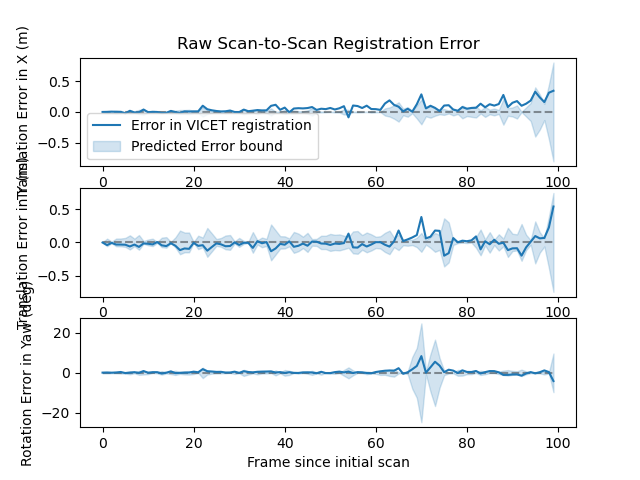

Text(0, 0.5, 'Rotation Error in Yaw (deg)')

In [83]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(3,1)
ax[0].set_title("Raw Scan-to-Scan Registration Error")
ax[0].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[0].plot(A_hist[:,0], label = 'Error in VICET registration', color = 'C0')
ax[0].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = abs(A_hist[:,6]),
                y2 = -abs(A_hist[:,6]), 
                color = 'C0', alpha = 0.2,  label = "Predicted Error bound")
# ax[0].set_xlabel("Frame since keyframe scan")
ax[0].set_ylabel("Translation Error in X (m)")
ax[0].legend(loc = 'best')

ax[1].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[1].plot(A_hist[:,1], label = 'Error in VICET registration', color = "C0")
ax[1].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = abs(A_hist[:,7]),
                y2 = -abs(A_hist[:,7]), 
                color = 'C0', alpha = 0.2,  label = "Predicted Error bound")
# ax[1].set_xlabel("Frame since initial scan")
ax[1].set_ylabel("Translation Error in Y (m)")
# ax[1].legend(loc = 'best')

ax[2].plot(np.zeros(len(A_hist)), 'k--', alpha = 0.4)
ax[2].plot(np.rad2deg(A_hist[:,5]), label = 'Error in VICET registration', color = "C0")
ax[2].fill_between(np.linspace(0,len(A_hist)-1, len(A_hist)), 
                y1 = abs(np.rad2deg(A_hist[:,11])),
                y2 = -abs(np.rad2deg(A_hist[:,11])), 
                color = 'C0', alpha = 0.2,  label = "Predicted Error bound")
ax[2].set_xlabel("Frame since initial scan")
ax[2].set_ylabel("Rotation Error in Yaw (deg)")
# ax[2].legend(loc = 'best')

# np.save("results/VICET/VICET_constant_keyframe_05_start_from_1800_v1", A_hist)

# compare with LOAM errors for frames 1800-1850 (moving start):

In [108]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 4

# fn = "results/LOAM/05_LOAM_start_from_1800_v1.npy"
fn = "results/LOAM/05_LOAM_start_from_1800_v2.npy"
# fn = "results/LOAM/05_LOAM_start_from_1790_v1.npy"# start_idx = 1789
LOAM_traj = np.load(fn)
# LOAM_traj =  LOAM_traj[10:,:]
# LOAM_traj =  LOAM_traj[1:,:] #test
# LOAM_traj =  LOAM_traj[2:,:] - LOAM_traj[2,:] #might looks better??

#init raw LOAM trajectory and OG LOAM axis
LOAM_axis = np.eye(3)
start_idx = 1799 #1800 

end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
disp.append(start_point)

rot_mat = R.from_euler('xyz', [np.deg2rad(2.), np.deg2rad(50.25), np.deg2rad(0)]).as_matrix() #was this
# rot_mat = R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(46.5), np.deg2rad(0)]).as_matrix() #for 1790
LOAM_corr = LOAM_traj[:,:3] @ rot_mat 
# LOAM_axis = LOAM_axis @ rot_mat
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
#was this
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
#test
gt_lidarframe = np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1)

gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
#rotate 180 deg about vertical axis to align with LOAM results
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(0), np.deg2rad(0)]).as_matrix() #test
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(0), np.deg2rad(-110)]).as_matrix() #test
gt_points = Line(gt_lidarframe[start_idx:start_idx+len(LOAM_traj),:3], c = "black", lw = 4, alpha = 0.5).legend("Actual Motion of Platform")
disp.append(gt_points)

#show LOAM corrected
LOAM_pts = Line(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, lw = 4).legend("LOAM")
disp.append(LOAM_pts)

A_hist = np.load('results/VICET/VICET_constant_keyframe_05_start_from_1800_v1.npy')

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(300)]).as_matrix() #new
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.2)) ##CB2314
lb = LegendBox([gt_points, start_point, LOAM_pts], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Plot LOAM Odometry with VICET Error Bounds

<IPython.core.display.Javascript object>


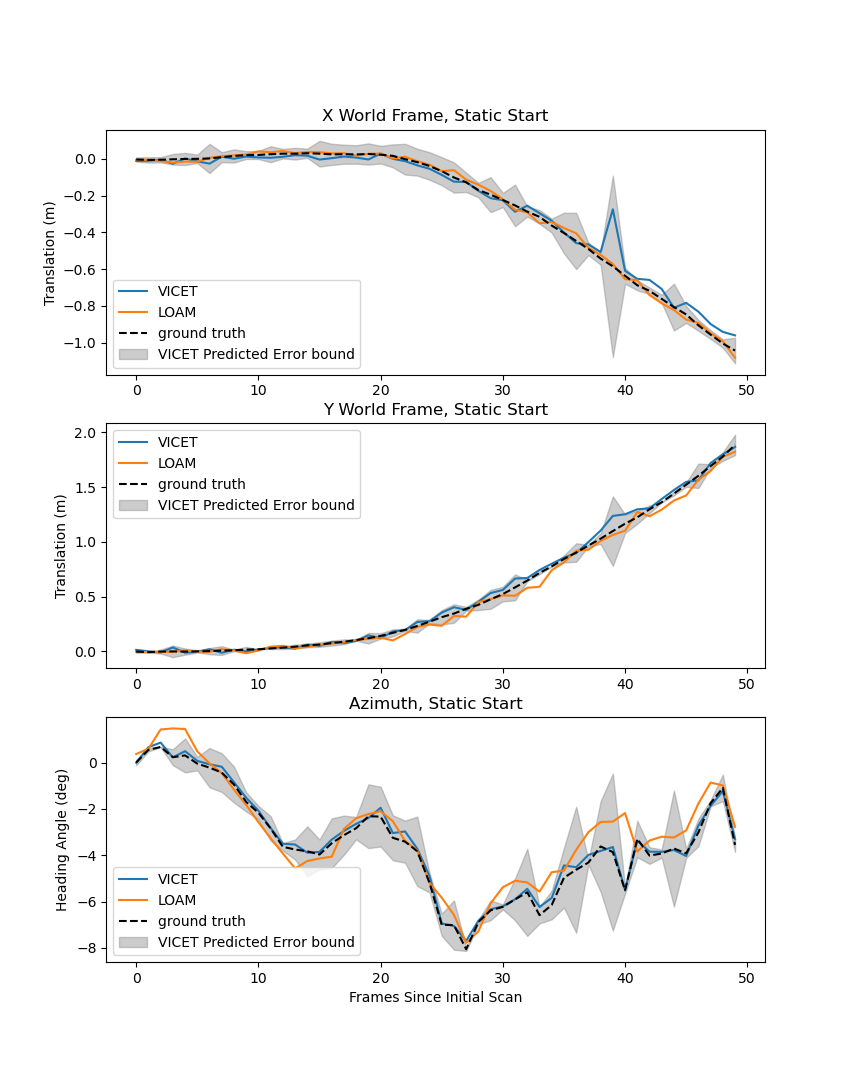

In [200]:
from matplotlib import pyplot as plt
view_len = 52 #works best for moving start
# view_len = len(A_hist) #show all data (need to comment out bounds)
ss = 2 #0 #skip start

fig,ax = plt.subplots(3,1)

# ax[0].set_title("X World Frame, Moving Start")
ax[0].set_title("X World Frame, Static Start")
ax[0].set_ylabel("Translation (m)")
# ax[0].plot(gt_lidarframe[start_idx:start_idx+view_len,0] + A_hist[:view_len,0],
#            label = 'VICET', color = 'C0')
ax[0].plot(gt_lidarframe[ss+start_idx:start_idx+view_len,0] + A_hist[ss:view_len,0] + A_hist[ss:view_len,6] ,
           label = 'VICET', color = 'C0') #motion state corrections applied
ax[0].plot(LOAM_corr[ss:view_len,0], label = 'LOAM', color = "C1")
ax[0].plot(gt_lidarframe[ss+start_idx:start_idx+view_len,0], 'k--', label = 'ground truth')
ax[0].fill_between(np.linspace(0,view_len-1-ss, view_len-ss), 
                y1 = gt_lidarframe[ss+start_idx:start_idx+view_len,0] + abs(A_hist[ss:view_len,6]),
                y2 = gt_lidarframe[ss+start_idx:start_idx+view_len,0] - abs(A_hist[ss:view_len,6]), 
                color = 'gray', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[0].legend(loc='best')

# ax[1].set_title("Y World Frame, Moving Start")
ax[1].set_title("Y World Frame, Static Start")
ax[1].set_ylabel("Translation (m)")
ax[1].plot(gt_lidarframe[ss+start_idx:start_idx+view_len,1] + A_hist[ss:view_len,1], label = 'VICET', color = 'C0')
ax[1].plot(LOAM_corr[ss:view_len,1], label = 'LOAM', color = "C1")
ax[1].plot(gt_lidarframe[ss+start_idx:start_idx+view_len,1], 'k--', label = 'ground truth')
ax[1].legend(loc='best')
ax[1].fill_between(np.linspace(0,view_len-1-ss, view_len-ss), 
                y1 = gt_lidarframe[start_idx+ss:start_idx+view_len,1] + abs(A_hist[ss:view_len,7]),
                y2 = gt_lidarframe[start_idx+ss:start_idx+view_len,1] - abs(A_hist[ss:view_len,7]), 
                color = 'gray', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[1].legend(loc='best')

#was this
# gt_euls = R.from_quat(qxyzw).as_euler('xyz') 
#correct for axis palcement at initial pose??
gt_euls = R.from_matrix(np.linalg.pinv(poses[start_idx,:3,:3]) @ R.from_quat(qxyzw).as_matrix()).as_euler('xyz')  

# print(gt_euls)

# ax[2].set_title("Azimuth, Moving Start")
ax[2].set_title("Azimuth, Static Start")
# ax[2].plot(np.rad2deg(LOAM_traj[:view_len,4]) + np.rad2deg(gt_euls[start_idx:start_idx+view_len,2] - gt_euls[start_idx,2]), label = 'LOAM')
ax[2].plot(np.rad2deg(gt_euls[ss+start_idx:start_idx+view_len,2] - gt_euls[ss+start_idx,2] + A_hist[ss:view_len,5]), label = 'VICET', color = "C0")

# ax[2].plot(np.rad2deg(LOAM_traj[:view_len,4]), label = 'LOAM', color = "C1")
#NOTE: need to account for offset in gt_euls (only in some trials)
# ax[2].plot(np.rad2deg(LOAM_traj[2:view_len+2,4] - LOAM_traj[2,4])  , label = 'LOAM', color = "C1")  #was  this
ax[2].plot(np.rad2deg(LOAM_traj[1+ss:view_len+1,4] - LOAM_traj[1,4])  , label = 'LOAM', color = "C1") #start at 1800??

ax[2].plot(np.rad2deg(gt_euls[ss+start_idx:start_idx+view_len,2] - gt_euls[ss+start_idx,2]), 'k--', label = 'ground truth')
ax[2].set_xlabel("Frames Since Initial Scan")
ax[2].set_ylabel("Heading Angle (deg)")
ax[2].fill_between(np.linspace(0,view_len-1-ss, view_len-ss), 
                y1 = np.rad2deg(gt_euls[start_idx+ss:start_idx+view_len,2] + abs(A_hist[ss:view_len,11]) - gt_euls[ss+start_idx,2]),
                y2 = np.rad2deg(gt_euls[start_idx+ss:start_idx+view_len,2] - abs(A_hist[ss:view_len,11]) - gt_euls[ss+start_idx,2]), 
                color = 'gray', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[2].legend(loc = 'best')

<IPython.core.display.Javascript object>


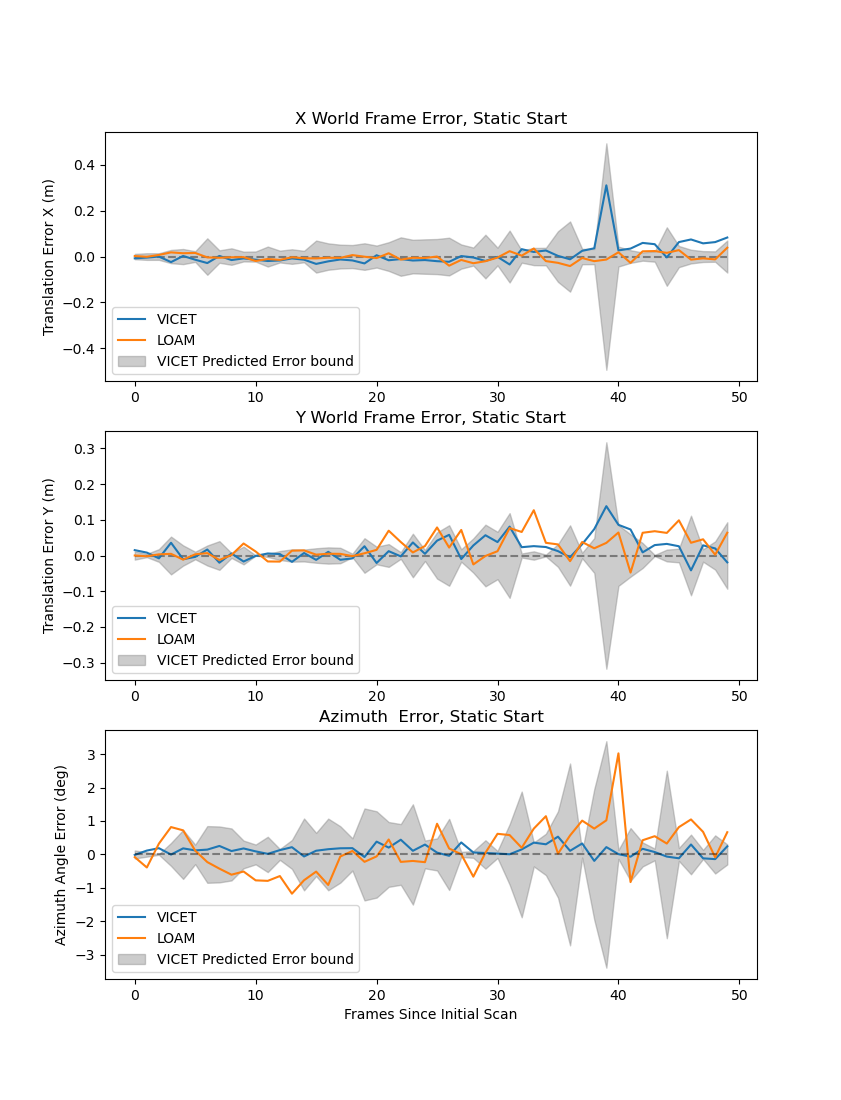

In [195]:
#plot error vs error bounds
from matplotlib import pyplot as plt
view_len = 52 #works best for moving start
# view_len = len(A_hist) #show all data
ss = 2 #0 #skip start

fig,ax = plt.subplots(3,1)
# ax[0].set_title("X World Frame Error, Static Start")
ax[0].set_title("X World Frame Error, Static Start")
ax[0].set_ylabel("Translation Error X (m)")
ax[0].plot(np.zeros(view_len-ss), 'k--', alpha = 0.4)
# ax[0].plot(A_hist[:view_len,0], label = 'VICET', color = 'C0') #was this
ax[0].plot(A_hist[ss:view_len,0] + A_hist[ss:view_len,6], label = 'VICET', color = 'C0') #test
ax[0].plot(gt_lidarframe[ss+start_idx:start_idx+view_len, 0] - LOAM_corr[ss:view_len,0], label = 'LOAM', color='C1')
ax[0].fill_between(np.linspace(0,view_len-1-ss, view_len-ss), 
                y1 =  abs(A_hist[ss:view_len,6]),
                y2 = -abs(A_hist[ss:view_len,6]), 
                color = 'gray', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[0].legend(loc='lower left')

# ax[1].set_title("Y World Frame Error, Moving Start")
ax[1].set_title("Y World Frame Error, Static Start")
ax[1].set_ylabel("Translation Error Y (m)")
ax[1].plot(np.zeros(view_len-ss), 'k--', alpha = 0.4)
ax[1].plot(A_hist[ss:view_len,1], label = 'VICET', color = 'C0')
# ax[1].plot(gt_lidarframe[start_idx:start_idx+view_len, 1] - LOAM_corr[:view_len,1], label = 'LOAM', color='C1')
frameToFrameLOAMError = gt_lidarframe[ss+start_idx:start_idx+view_len, 1] - LOAM_corr[ss:view_len,1]
# frameToFrameLOAMError = gt_lidarframe[start_idx+1:start_idx+view_len+1, 1] - LOAM_corr[:view_len,1]
frameToFrameLOAMError[0] = 0
ax[1].plot(frameToFrameLOAMError, label = 'LOAM', color='C1')
ax[1].fill_between(np.linspace(0,view_len-1-ss, view_len-ss), 
                y1 = abs(A_hist[ss:view_len,7]),
                y2 = -abs(A_hist[ss:view_len,7]), 
                color = 'gray', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[1].legend(loc='lower left')
# ax[1].set_xlabel("Frames since Initial Scan")

gt_euls = R.from_quat(qxyzw).as_euler('xyz')
# ax[2].set_title("Azimuth  Error, Moving Start")
ax[2].set_title("Azimuth  Error, Static Start")
ax[2].plot(np.rad2deg(A_hist[ss:view_len,5]), label = 'VICET', color = 'C0')
# ax[2].plot(np.rad2deg(LOAM_traj[:view_len,4] - gt_euls[start_idx:start_idx+view_len,2] +  gt_euls[start_idx,2] ), label = 'LOAM', color = 'C1')
# #need to account for offset between ground truth and LIDAR scan indices (only on some trials)
ax[2].plot(np.rad2deg(LOAM_traj[ss+1:view_len+1,4] - LOAM_traj[2,4] - gt_euls[ss+start_idx:start_idx+view_len,2] +  gt_euls[start_idx,2] ), label = 'LOAM', color = 'C1')
# ax[2].plot(np.rad2deg(LOAM_traj[2:view_len+2,4] - LOAM_traj[2,4] - gt_euls[start_idx:start_idx+view_len,2] +  gt_euls[start_idx,2] ), label = 'LOAM', color = 'C1')

ax[2].plot(np.zeros(view_len-ss), 'k--', alpha = 0.4)
ax[2].set_xlabel("Frames Since Initial Scan")
ax[2].set_ylabel("Azimuth Angle Error (deg)")
ax[2].fill_between(np.linspace(0,view_len-1-ss, view_len-ss), 
                y1 = np.rad2deg(abs(A_hist[ss:view_len,11])),
                y2 = np.rad2deg(-abs(A_hist[ss:view_len,11])), 
                color = 'gray', alpha = 0.4,  label = "VICET Predicted Error bound")
ax[2].legend(loc = 'lower left')

# compare LOAM vs VICET error bound on frames ~2020-2070 (staticish start):

In [173]:
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 4

#init raw LOAM trajectory and OG LOAM axis
# fn = "results/LOAM/05_LOAM_start_from_static.npy"
# fn = "results/LOAM/05_LOAM_start_from_static_v2.npy"
# fn = "results/LOAM/05_LOAM_start_from_static_v4.npy" #new 7/24-- starts 10 frames earlier
fn = "results/LOAM/05_LOAM_start_from_static_v5.npy"
LOAM_traj = np.load(fn)
# LOAM_traj =  LOAM_traj[10:,:] #for v4 -- 7/24


LOAM_axis = np.eye(3)
# start_idx = 2010 #for new test (6/28)
start_idx = 2031 #2030 #better??
end_idx = start_idx + len(LOAM_traj) #3341
start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
disp.append(start_point)

rot_mat = R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(26), np.deg2rad(-2)]).as_matrix() #test
LOAM_corr = LOAM_traj[:,:3] @ rot_mat
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(-30)]).as_matrix() #test
gt_points = Line(gt_lidarframe[2000:3000,:3], c = "black", lw = 4, alpha = 0.5).legend("Actual Motion of Platform")
disp.append(gt_points)
#show LOAM corrected
LOAM_pts = Line(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, lw = 4).legend("LOAM")
disp.append(LOAM_pts)

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix()
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.2)) ##CB2314

#get VICET trajectory~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
start_idx_VICET = 2020 #static start
# VICET_A_hist = np.load("results/VICET/VICET_constant_keyframe_05_start_from_2020_v1.npy")
VICET_A_hist = np.load("results/VICET/VICET_constant_keyframe_05_start_from_2020_v2.npy")
# VICET_A_hist = np.load("results/VICET/VICET_constant_keyframe_05_start_from_2020_v3.npy")
A_hist = VICET_A_hist[:100,:]

# VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + 
#               VICET_A_hist[:,:3] + VICET_A_hist[:,6:9])
VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + VICET_A_hist[:,:3])
# VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3])

#line up at start
VICET_traj -= VICET_traj[0,:]
#rotate to align with gt
VICET_traj = VICET_traj @ R.from_euler('xyz', [0,0,np.deg2rad(190)]).as_matrix()

# VICET_points = Points(VICET_traj[:,:3], c='green', r=ptsize, alpha = 0.8).legend("VICET")
VICET_points = Line(VICET_traj[:,:3], lw = 3, c='green', alpha = 1).legend("VICET")
disp.append(VICET_points)

lb = LegendBox([gt_points, start_point, LOAM_pts, VICET_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# start from near very beginning at frame 280 in first ROSBAG (actual static start)

In [68]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 4

#init raw LOAM trajectory and OG LOAM axis
fn = "results/LOAM/05_LOAM_start_from_280_v1.npy"
LOAM_traj = np.load(fn)
# LOAM_traj =  LOAM_traj[10:,:] #was this


LOAM_axis = np.eye(3)
start_idx = 290
end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
disp.append(start_point)

#rotate 135 deg about y axis to align initial motion with +x 
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(135), 0]).as_matrix() #was this for 678
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(28), 0]).as_matrix() #test
rot_mat = R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(26), np.deg2rad(-2)]).as_matrix() #test
LOAM_corr = LOAM_traj[:,:3] @ rot_mat
# LOAM_axis = LOAM_axis @ rot_mat
LOAM_axis = LOAM_axis @ R.from_euler('xyz', [0, np.deg2rad(0), np.deg2rad(-2)]).as_matrix() #test
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
#rotate 180 deg about vertical axis to align with LOAM results
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(180)]).as_matrix() #was this
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(225)]).as_matrix() #for test 678
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(-30)]).as_matrix() #test
# gt_points = Points(gt_lidarframe[2000:3000,:3], c = "black", r=3).legend("Actual Motion of Platform")
gt_points = Line(gt_lidarframe[2000:3000,:3], c = "black", lw = 4, alpha = 0.5).legend("Actual Motion of Platform")
disp.append(gt_points)

#show LOAM corrected
LOAM_pts = Line(LOAM_corr[:,:3], c = 'purple', alpha = 0.5, lw = 4).legend("LOAM")
disp.append(LOAM_pts)

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
# submap_mapframe = (poses[start_idx] @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix()
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.2)) ##CB2314

#get VICET trajectory~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
start_idx_VICET = 2020 #static start
VICET_A_hist = np.load("results/VICET/VICET_constant_keyframe_05_start_from_2020_v1.npy")
# VICET_A_hist = np.load("results/VICET/VICET_constant_keyframe_05_start_from_2020_v2.npy")
A_hist = VICET_A_hist[:100,:]

# VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + 
#               VICET_A_hist[:,:3] + VICET_A_hist[:,6:9])
VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + VICET_A_hist[:,:3])
# VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3])

#line up at start
VICET_traj -= VICET_traj[0,:]
#rotate to align with gt
VICET_traj = VICET_traj @ R.from_euler('xyz', [0,0,np.deg2rad(190)]).as_matrix()

# VICET_points = Points(VICET_traj[:,:3], c='green', r=ptsize, alpha = 0.8).legend("VICET")
VICET_points = Line(VICET_traj[:,:3], lw = 3, c='green', alpha = 1).legend("VICET")
disp.append(VICET_points)

lb = LegendBox([gt_points, start_point, LOAM_pts, VICET_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)